Jupyter Notebook to Apply XGBoost and Compute Performance of Classification, utilizes bundlenet.py library (among others)

In [104]:
from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import bundlenet as bn
from dipy.io.streamline import load_trk, save_trk
from sklearn.metrics import precision_recall_fscore_support as score
import nibabel as nib
import time 

Load in probabilities for subjects to train XGBoost

In [2]:
subj='970764'
loaded_from_file = np.load('model_p/p_subj'+ subj + '_nclass16_do0_nc3_fc1.npz')
labels_concat = loaded_from_file['labels']
p_concat = loaded_from_file['p']
for subj in '972566','973770','978578','979984','983773':
    loaded_from_file = np.load('model_p/p_subj'+ subj + '_nclass16_do0_nc3_fc1.npz')
    labels_subj = loaded_from_file['labels']
    p_subj = loaded_from_file['p']
    labels_concat = np.concatenate((labels_concat,labels_subj))
    p_concat = np.concatenate((p_concat,p_subj))

Load in test subject 

In [3]:
subj='984472'
loaded_from_file = np.load('model_p/p_subj'+ subj + '_nclass16_do0_nc3_fc1.npz')
labels_test = loaded_from_file['labels']
p_test = loaded_from_file['p']
p_bund_test = np.argmax(p_test,axis=1)
prob_bund_test = np.max(p_test,axis=1)

Convert values to two classes (0/1) and run XGBoost (to learn which streamlines to throw away)

In [4]:
labels_concat_2class = labels_concat.copy()
labels_concat_2class[labels_concat_2class<16] = 0
labels_concat_2class[labels_concat_2class==16] = 1
labels_test_2class = labels_test.copy()
labels_test_2class[labels_test_2class<16] = 0
labels_test_2class[labels_test_2class==16] = 1
p_2class = bn.run_xgboost(p_concat,labels_concat_2class,p_test,labels_test_2class,10,2,0.5)

Calculate precision and recall for XGBoost

In [5]:
precision, recall, fscore, support = score(labels_test_2class,p_2class)

In [6]:
precision

array([0.83554233, 0.96804158])

In [7]:
recall

array([0.80898288, 0.97321733])

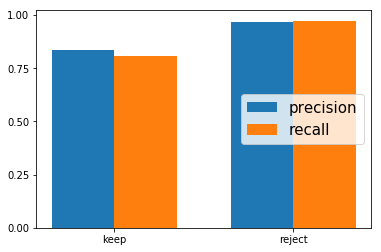

In [8]:
ind = np.arange(2) 
width = 0.35       
plt.bar(ind, precision, width, label='precision')
plt.bar(ind + width, recall, width,
    label='recall')
plt.xticks(ind + width / 2, ('keep', 'reject'))
plt.legend(loc='right',fontsize='15')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.savefig('precisionrecallbar_allsl.jpg')

Filter out the rejected streamlines

In [9]:
keep = p_2class==0
labels = labels_test[keep]
p_idx = np.argmax(p_test,axis=-1)
p = p_idx[keep]

In [10]:
bundle_files = sorted(glob('/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/*.trk'))
bundle_names = []
for fname in bundle_files:
    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    

In [11]:
bundle_names

['AF_L',
 'AF_R',
 'CCMid',
 'CC_ForcepsMajor',
 'CC_ForcepsMinor',
 'CST_L',
 'CST_R',
 'C_L',
 'C_R',
 'F_L',
 'F_R',
 'IF0F_R',
 'IFOF_L',
 'MCP',
 'UF_L',
 'UF_R']

Calculate precision and recall for bundle classification without and with XGBoost step

In [12]:
precision, recall, fscore, support = score(labels_test,p_idx)
precision = precision[0:16]
recall = recall[0:16]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


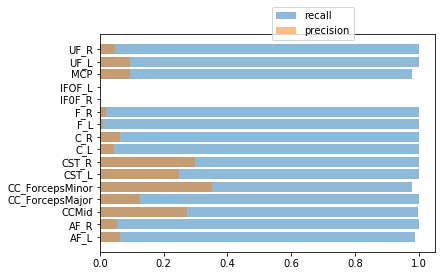

In [13]:
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.barh(np.arange(len(recall)), recall, align='center', alpha=0.5,label='recall')
plt.barh(np.arange(len(precision)), precision, align='center', alpha=0.5,label='precision')
plt.yticks(np.arange(len(precision)), bundle_names)
plt.legend(loc='center left', bbox_to_anchor=(0.5, 1.05))
plt.savefig('precisionrecallbar_noxgboost.pdf')

In [14]:
precision, recall, fscore, support = score(labels,p)
precision = precision[0:16]
recall = recall[0:16]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


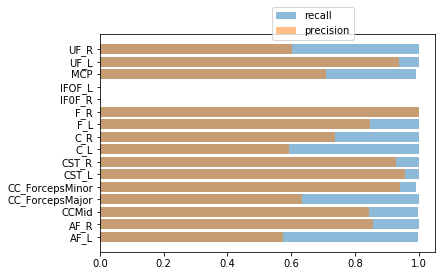

In [15]:
plt.barh(np.arange(len(recall)), recall, align='center', alpha=0.5,label='recall')
plt.barh(np.arange(len(precision)), precision, align='center', alpha=0.5,label='precision')
plt.yticks(np.arange(len(precision)), bundle_names)
plt.legend(loc='center left', bbox_to_anchor=(0.5, 1.05)) 
plt.savefig('precisionrecallbar.pdf')

In [16]:
np.mean(precision)

0.6975597742725136

Save out .trk files for visual check

In [17]:
streamlines_all_nomni = bn.read_sl('/home/ubuntu/copied16/sub-984472/sess-01/dwi/out_work/whole_brain_MNI_tracks_from_peaks__moved.trk')

In [18]:
sl_num=10
a = np.where(p_2class==0)[0]
b = np.where((p_bund_test==sl_num) & (prob_bund_test >0.9))[0]
sl_bn = np.intersect1d(a,b)

In [19]:
sl_reco = np.where(labels_test==sl_num)
sl_reco = sl_reco[0]

In [30]:
sl_both = np.intersect1d(sl_bn, sl_reco)
sl_justbn = np.setdiff1d(sl_bn, sl_reco)
sl_justreco = np.setdiff1d(sl_reco, sl_bn)

In [21]:
save_trk('slboth'+bundle_names[sl_num]+'.trk', streamlines=streamlines_all_nomni[sl_both], affine=np.eye(4))
save_trk('slbn'+bundle_names[sl_num]+'.trk', streamlines=streamlines_all_nomni[sl_justbn], affine=np.eye(4))
save_trk('slreco'+bundle_names[sl_num]+'.trk', streamlines=streamlines_all_nomni[sl_justreco], affine=np.eye(4))

In [22]:
save_trk('slunlabeled.trk', streamlines=streamlines_all_nomni[labels_test_2class==1], affine=np.eye(4))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1333847 but corresponding boolean dimension is 212157

In [ ]:
sl_bn = np.where((p_bund_test==sl_num) & (prob_bund_test >0.9))[0]
save_trk('slbn'+bundle_names[sl_num]+'_noxg.trk', streamlines=streamlines_all_nomni[sl_bn], affine=np.eye(4))

In [ ]:
for i, bund in enumerate(bundle_names):
    print(bund)
    bn.savesegtrk(streamlines_all_nomni, p_2class, p_bund_test, i, prob_bund_test, 0.9,'TRK/'+bund+'.trk',0)

In [20]:
import dipy.data as dpd
from dipy.data.fetcher import get_two_hcp842_bundles
model_af_l_file, model_cst_l_file = get_two_hcp842_bundles()

In [21]:
from dipy.data.fetcher import (fetch_target_tractogram_hcp,
                               fetch_bundle_atlas_hcp842,
                               get_bundle_atlas_hcp842,
                               get_target_tractogram_hcp)
atlas_file, atlas_folder = fetch_bundle_atlas_hcp842()


Data size is approximately 200MB
Dataset is already in place. If you want to fetch it again please first remove the folder /home/ubuntu/.dipy/bundle_atlas_hcp842 


In [22]:
model_af_l, hdr = load_trk(model_af_l_file)
model_cst_l, hdr = load_trk(model_cst_l_file)

In [23]:
from dipy.segment.metric import (AveragePointwiseEuclideanMetric,
                                 ResampleFeature)
from dipy.segment.clustering import QuickBundles

feature = ResampleFeature(nb_points=100)
metric = AveragePointwiseEuclideanMetric(feature)

In [24]:
qb = QuickBundles(np.inf, metric=metric)

cluster_cst_l = qb.cluster(model_cst_l)
standard_cst_l = cluster_cst_l.centroids[0]

cluster_af_l = qb.cluster(model_af_l)
standard_af_l = cluster_af_l.centroids[0]

In [25]:
sl_num=0
a = np.where(p_2class==0)[0]
b = np.where((p_bund_test==sl_num) & (prob_bund_test >0.9))[0]
sl_bn = np.intersect1d(a,b)
af_l=streamlines_all_nomni[sl_bn]

sl_num=5
a = np.where(p_2class==0)[0]
b = np.where((p_bund_test==sl_num) & (prob_bund_test >0.9))[0]
sl_bn = np.intersect1d(a,b)
cst_l=streamlines_all_nomni[sl_bn]

In [26]:
import dipy.segment.bundles as dsb

oriented_cst_l = dsb.orient_by_streamline(cst_l, standard_cst_l,
                                          affine=transform)
oriented_af_l = dsb.orient_by_streamline(af_l, standard_af_l,
                                         affine=transform)

AttributeError: module 'dipy.segment.bundles' has no attribute 'orient_by_streamline'

In [28]:
a = [np.amin(p) for p in streamlines_all_nomni[:][:,0]] 
b = [np.amin(p) for p in streamlines_all_nomni[:][:,1]] 
c = [np.amin(p) for p in streamlines_all_nomni[:][:,2]] 
add_on = -1 * np.array([np.min(a),np.min(b),np.min(c)])
streamlines_all_nomni_moved = [np.int_(np.round(s + add_on)) for s in streamlines_all_nomni]
aa = np.zeros([len(streamlines_all_nomni_moved),1])
bb = np.zeros([len(streamlines_all_nomni_moved),1])
cc = np.zeros([len(streamlines_all_nomni_moved),1])
for idx, i in enumerate(streamlines_all_nomni_moved):
    aa[idx] = np.amax(i[:,0])
    bb[idx] = np.amax(i[:,1])
    cc[idx] = np.amax(i[:,2])
max_x = np.int(np.amax(aa))
max_y = np.int(np.amax(bb))
max_z = np.int(np.amax(cc))
add_on

In [96]:
dc=[]
for sl_num in range(16):
    a = np.where(p_2class==0)[0]
    b = np.where((p_bund_test==sl_num) & (prob_bund_test >0.9))[0]
    sl_bn = np.intersect1d(a,b)
    sl_reco = np.where(labels_test==sl_num)
    sl_reco = sl_reco[0]
    bundle_sl_bn = [streamlines_all_nomni_moved[s] for s in sl_bn]
    image_bn = bn.createvisitationmaps(max_x,max_y,max_z,bundle_sl_bn)
    bundle_sl_reco = [streamlines_all_nomni_moved[s] for s in sl_reco]
    image_reco = bn.createvisitationmaps(max_x,max_y,max_z,bundle_sl_reco)
    tmp = bn.computedicecoef(image_bn,image_reco)
    dc.append(tmp)

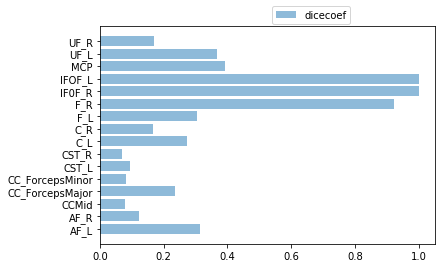

In [97]:
plt.barh(np.arange(len(dc)), dc, align='center', alpha=0.5,label='dicecoef')
plt.yticks(np.arange(len(dc)), bundle_names)
plt.legend(loc='center left', bbox_to_anchor=(0.5, 1.05)) 
plt.savefig('dcbar.pdf')

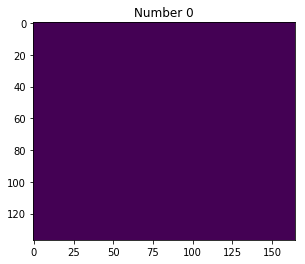

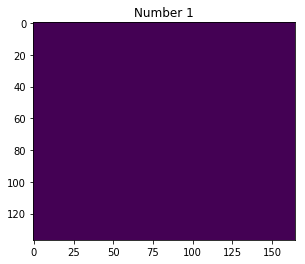

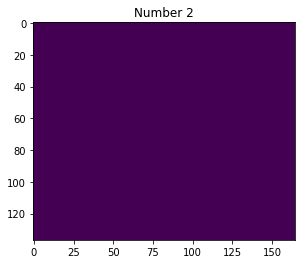

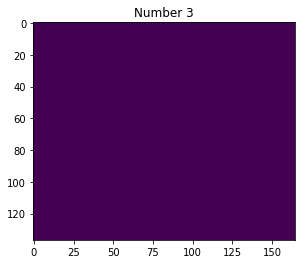

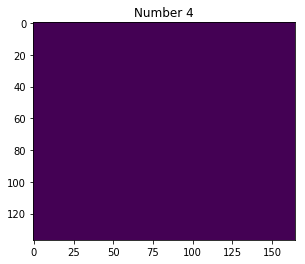

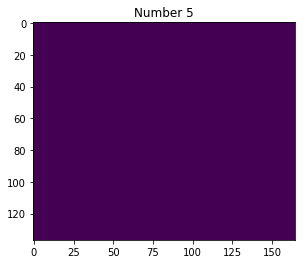

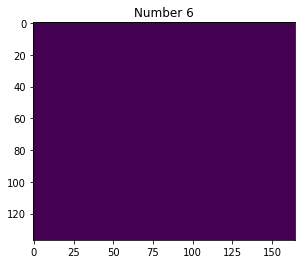

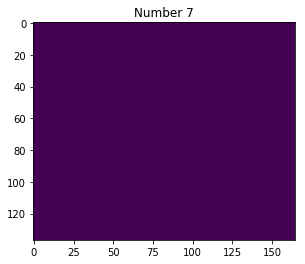

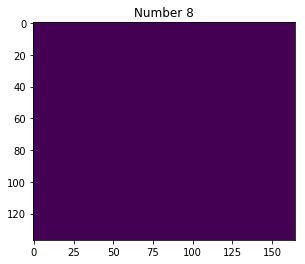

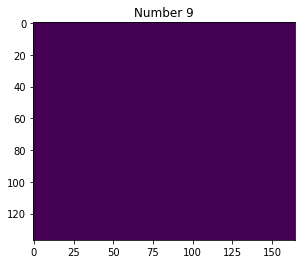

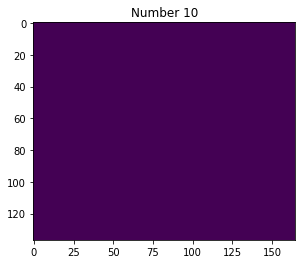

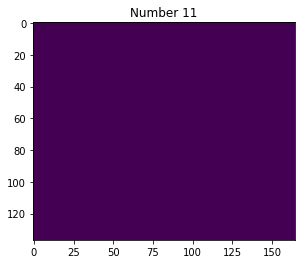

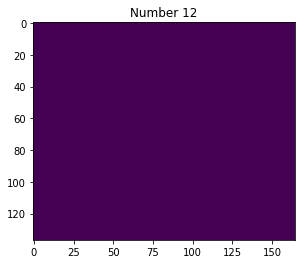

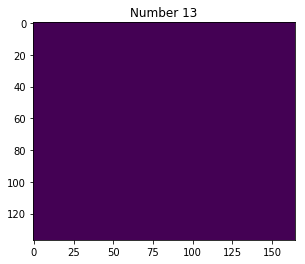

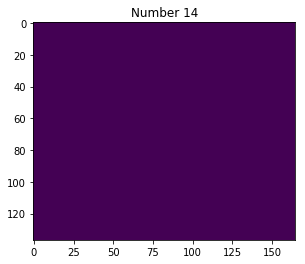

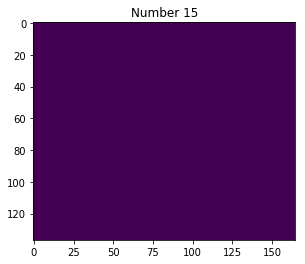

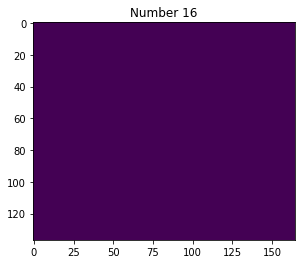

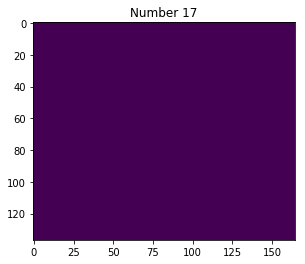

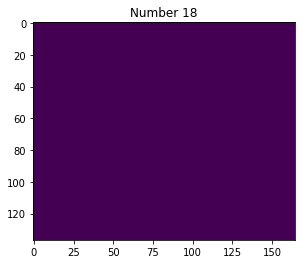

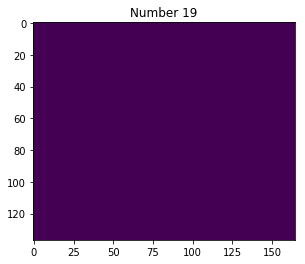

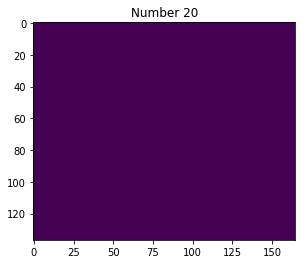

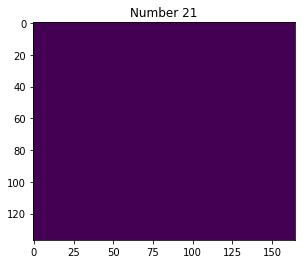

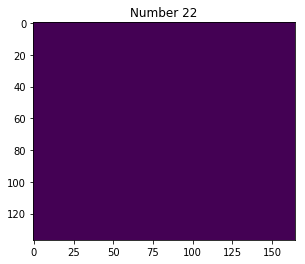

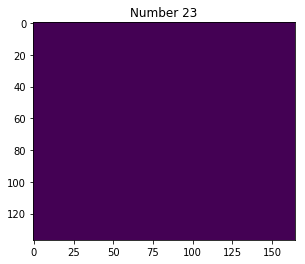

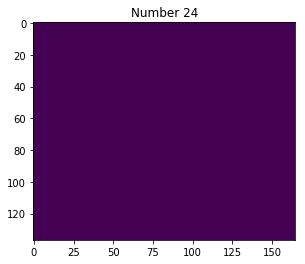

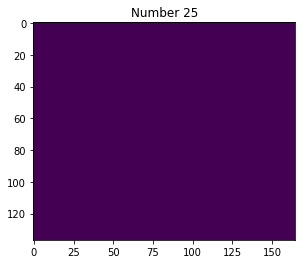

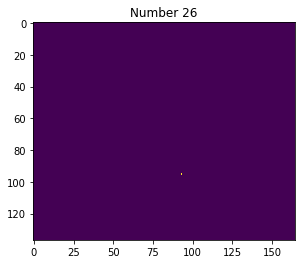

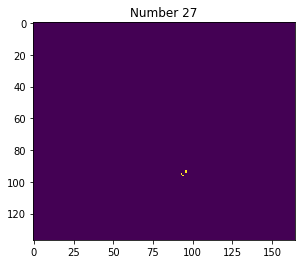

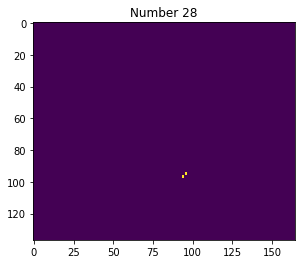

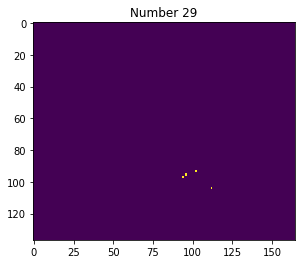

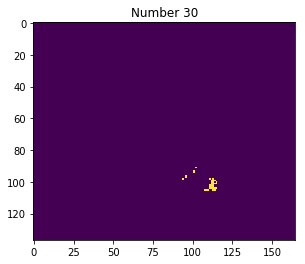

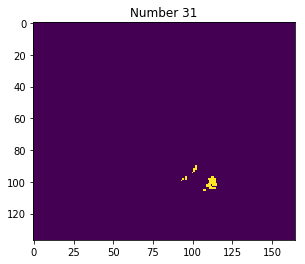

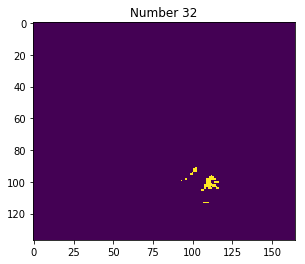

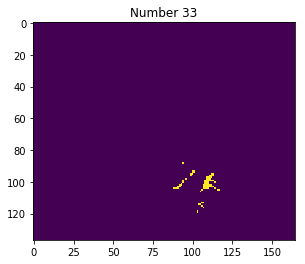

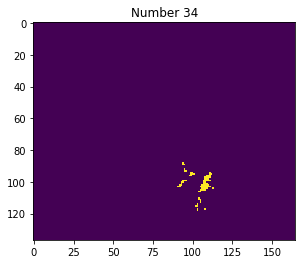

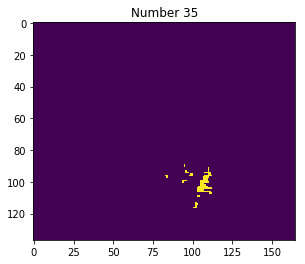

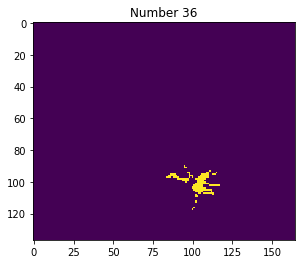

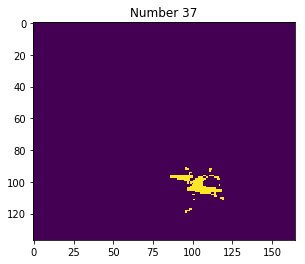

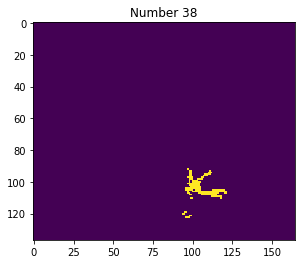

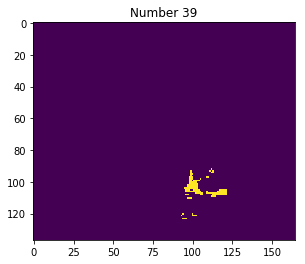

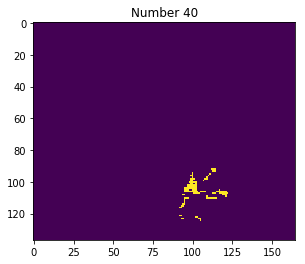

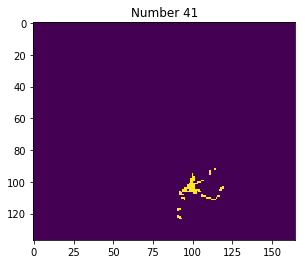

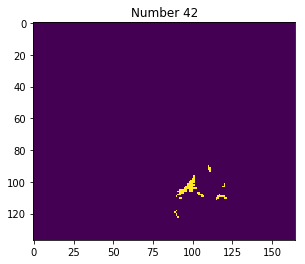

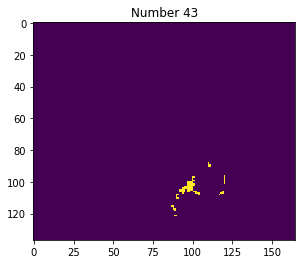

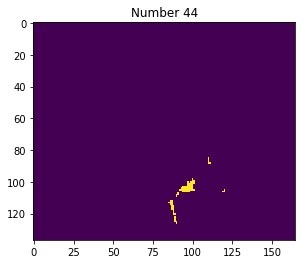

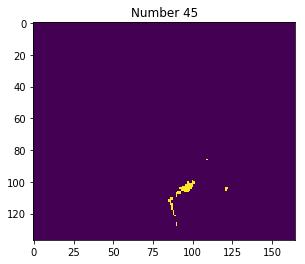

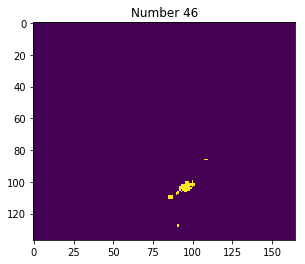

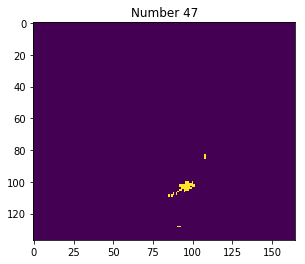

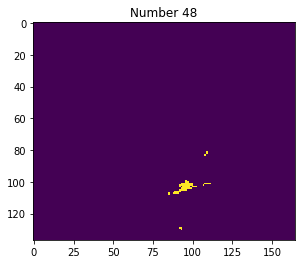

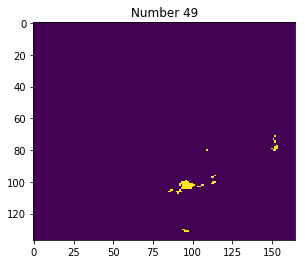

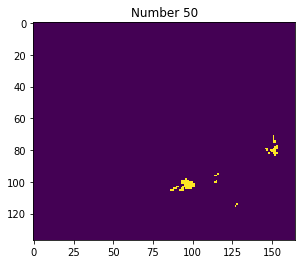

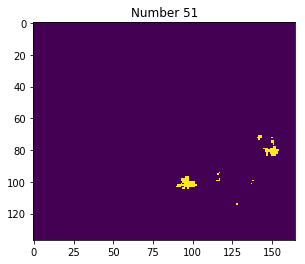

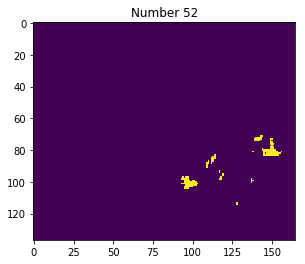

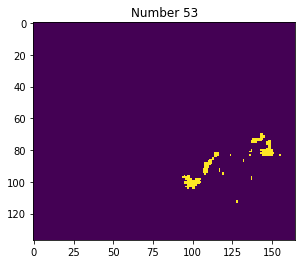

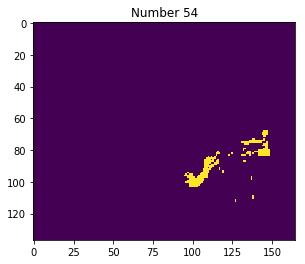

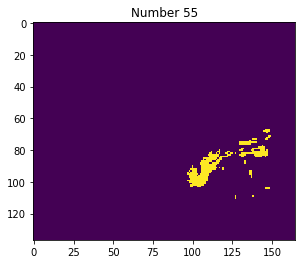

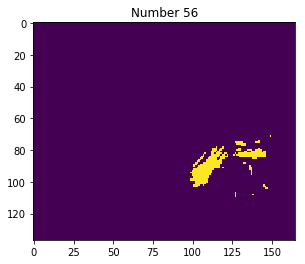

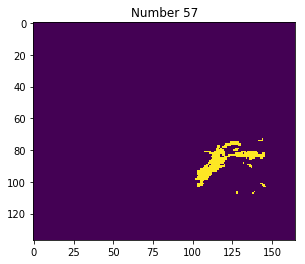

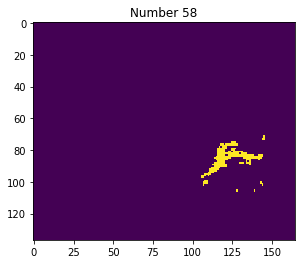

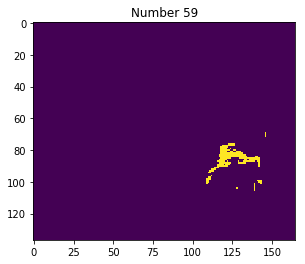

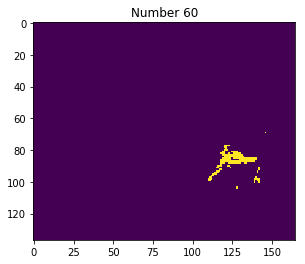

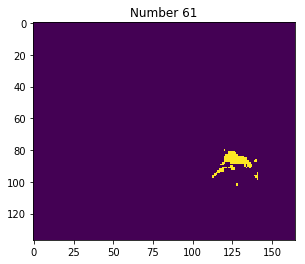

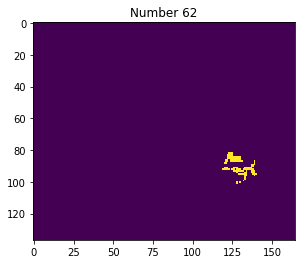

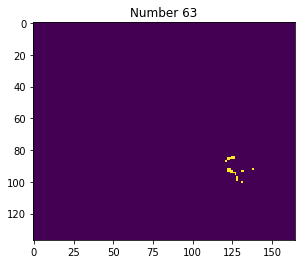

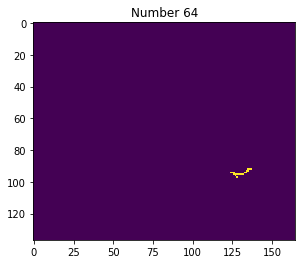

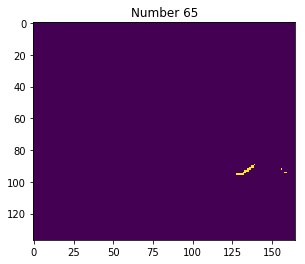

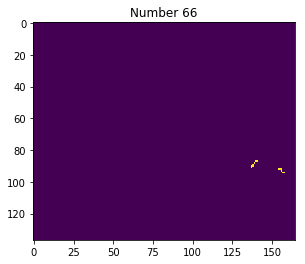

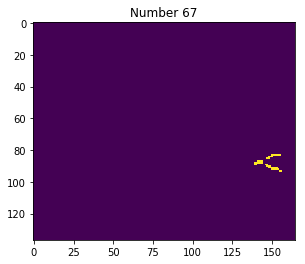

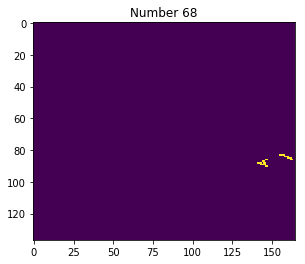

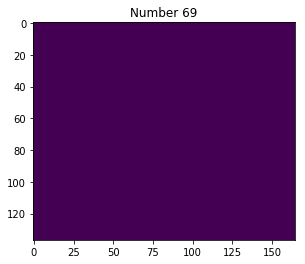

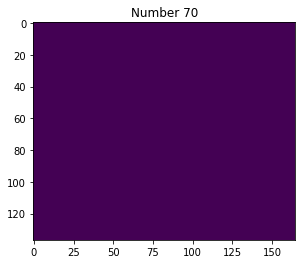

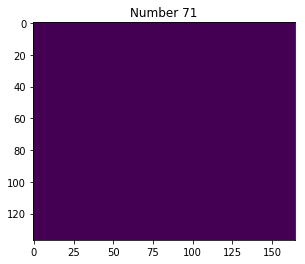

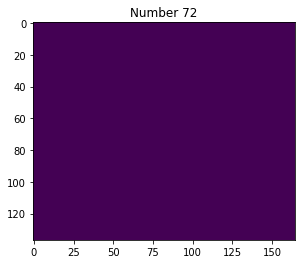

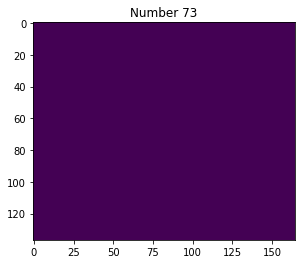

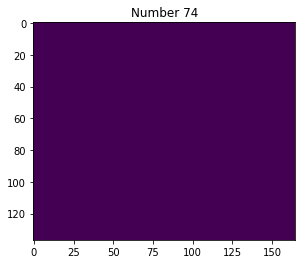

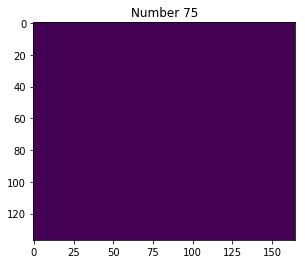

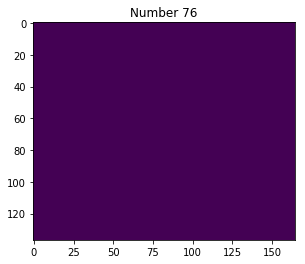

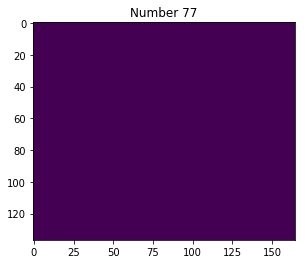

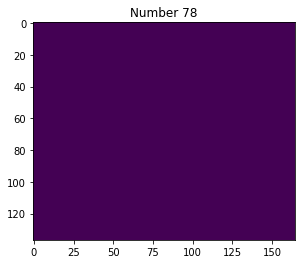

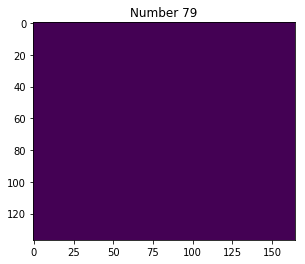

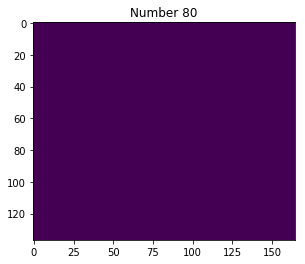

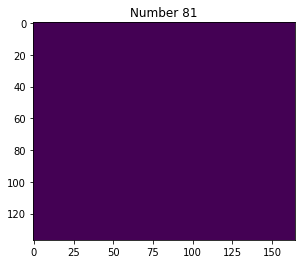

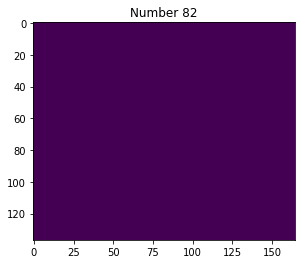

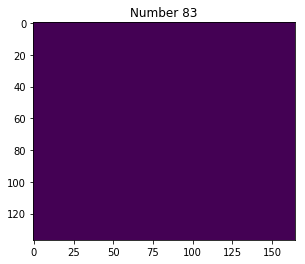

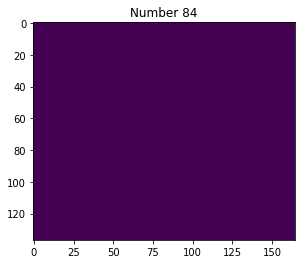

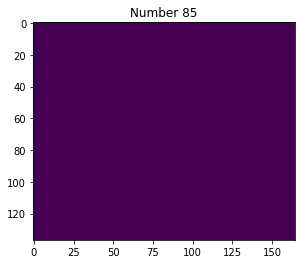

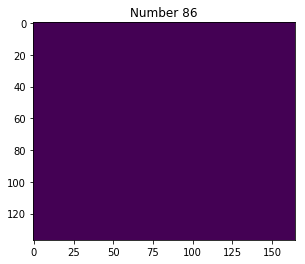

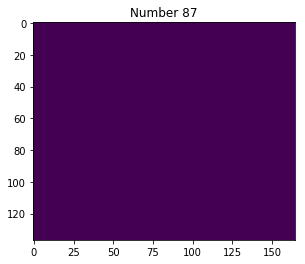

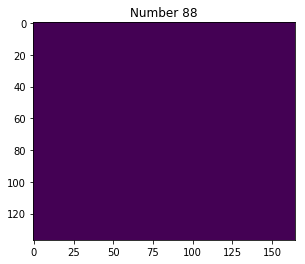

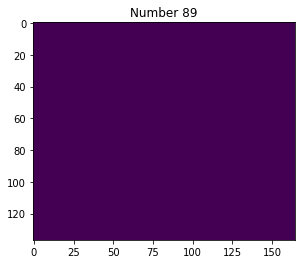

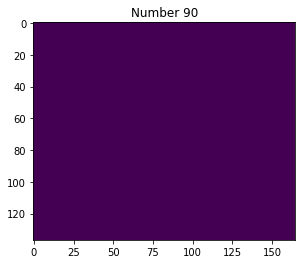

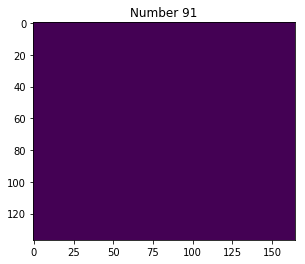

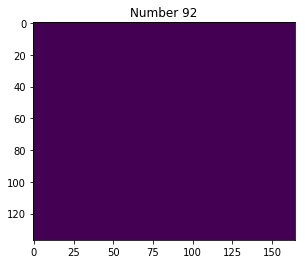

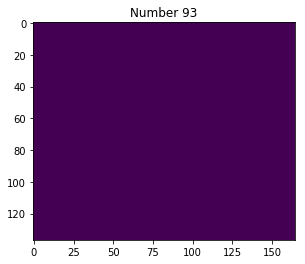

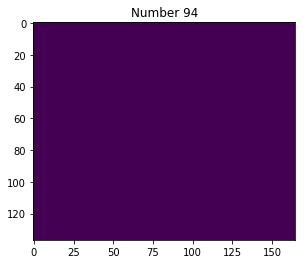

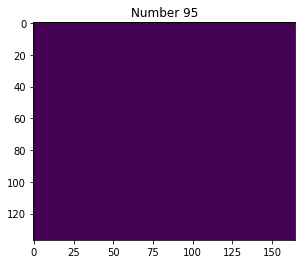

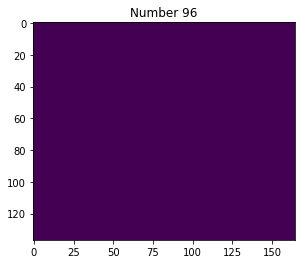

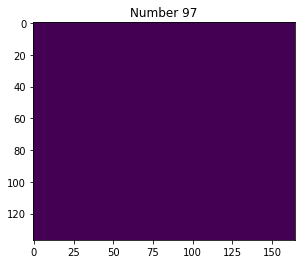

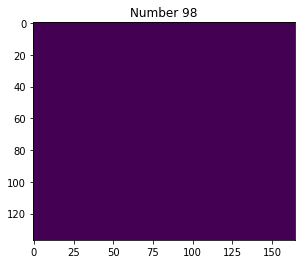

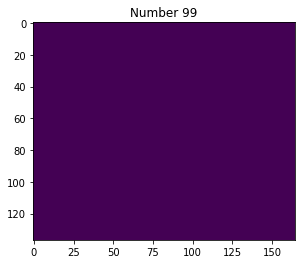

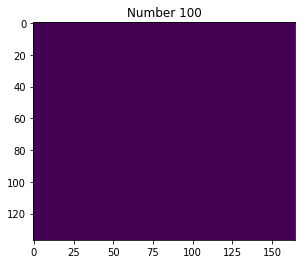

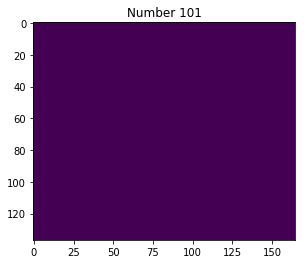

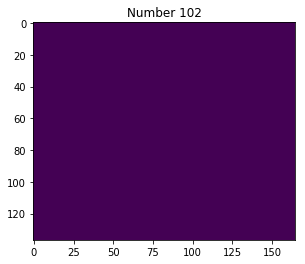

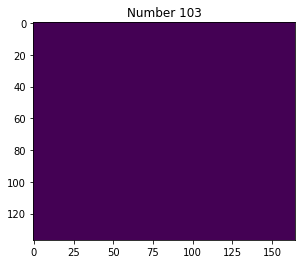

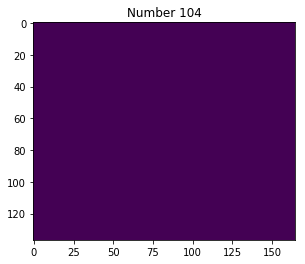

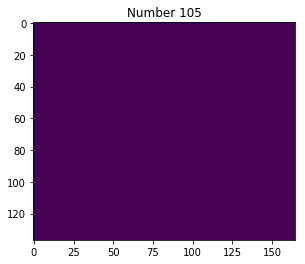

KeyboardInterrupt: 

In [123]:
plt.figure(1);
for j in range(0,image_bn.shape[2]):
    plt.imshow(image_bn[:,:,j])
    plt.title('Number ' + str(j))
    plt.pause(0.1)
    plt.close()


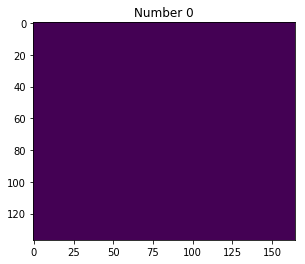

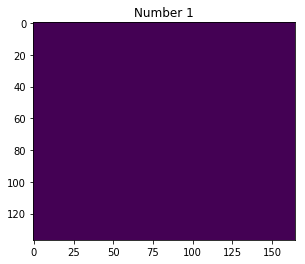

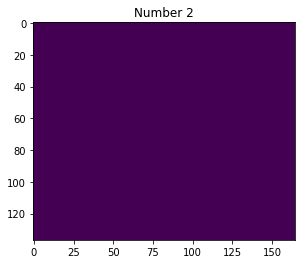

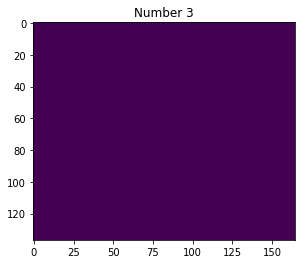

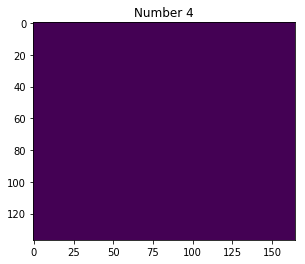

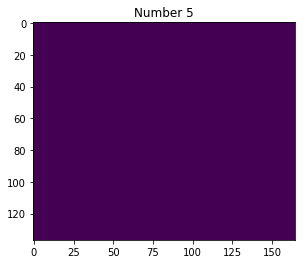

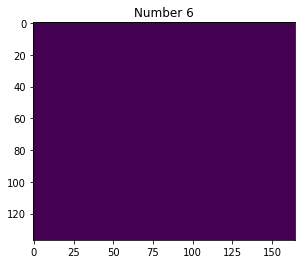

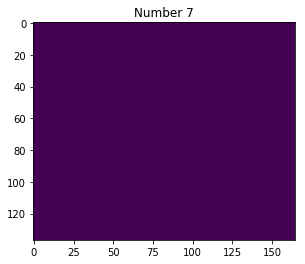

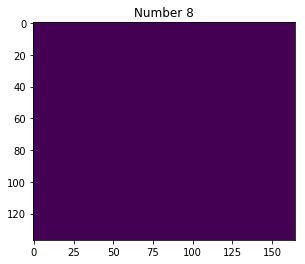

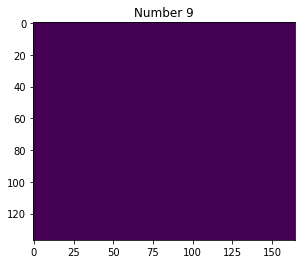

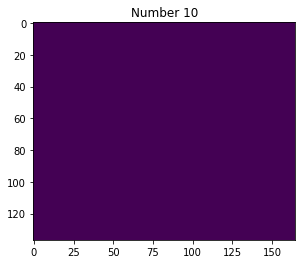

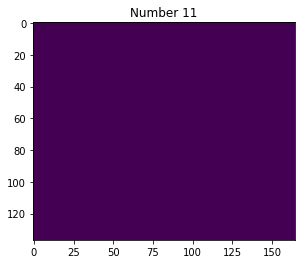

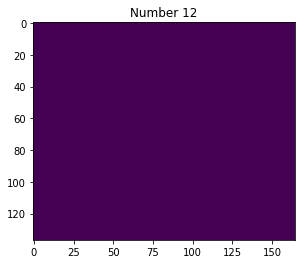

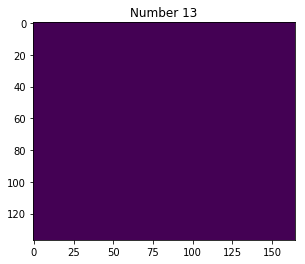

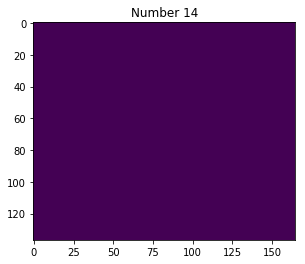

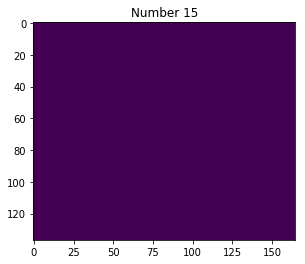

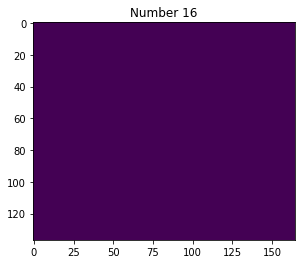

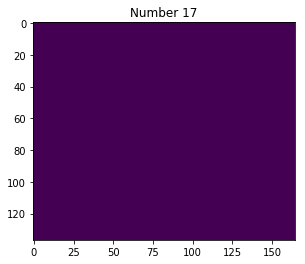

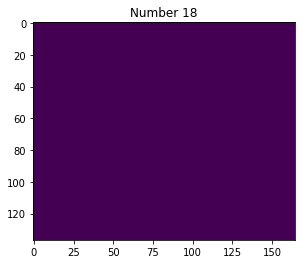

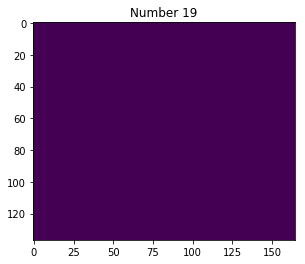

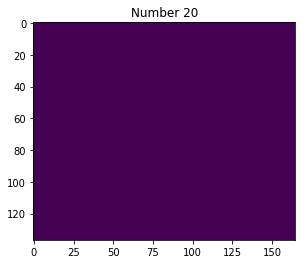

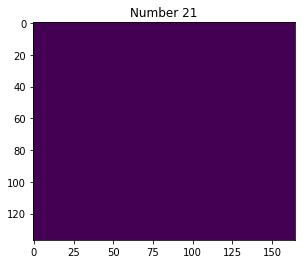

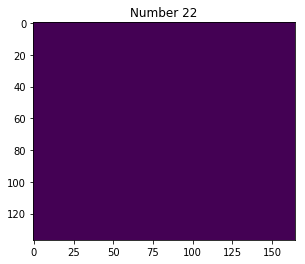

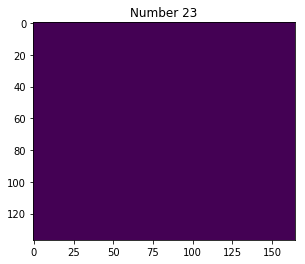

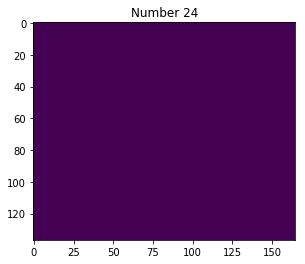

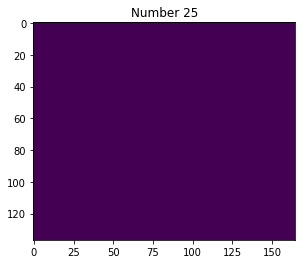

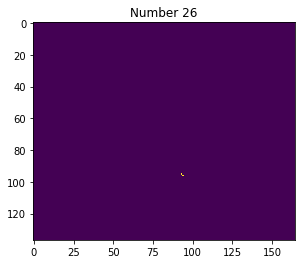

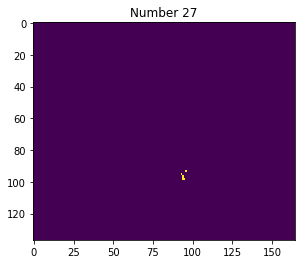

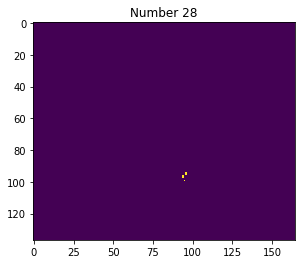

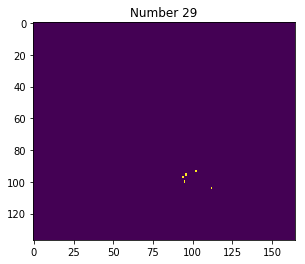

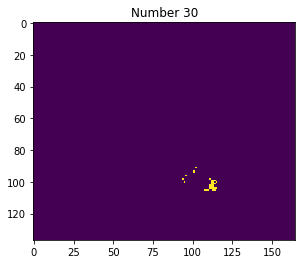

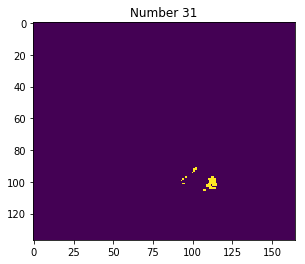

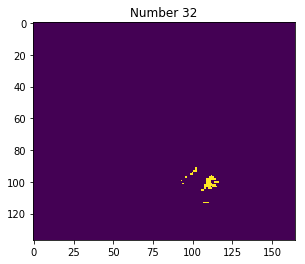

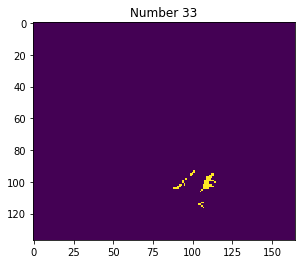

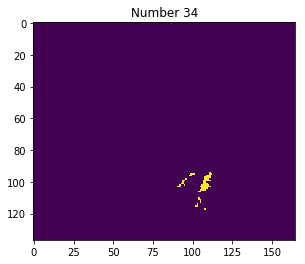

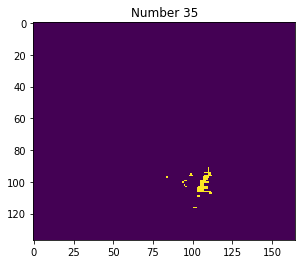

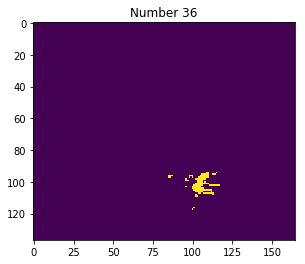

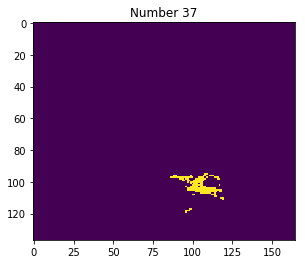

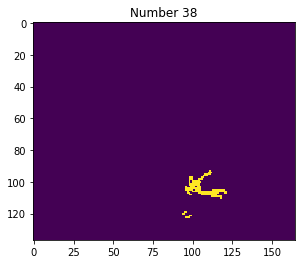

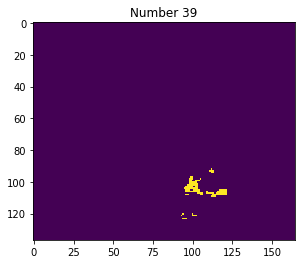

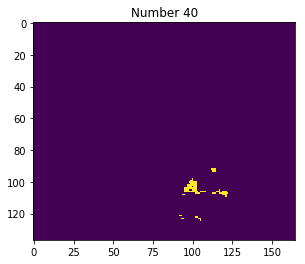

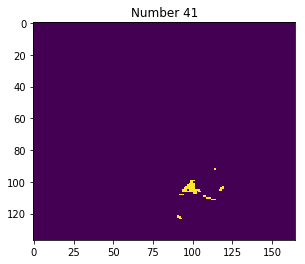

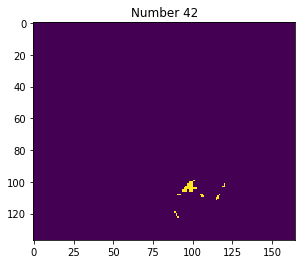

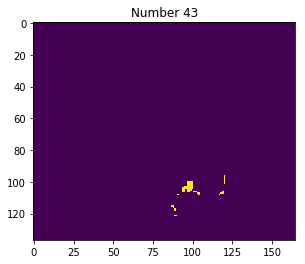

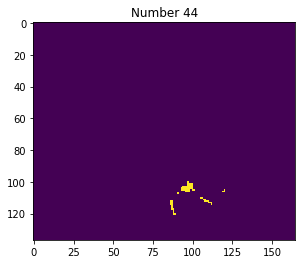

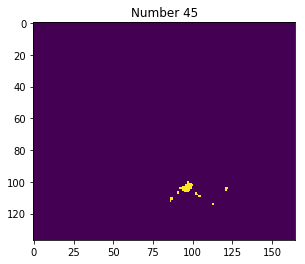

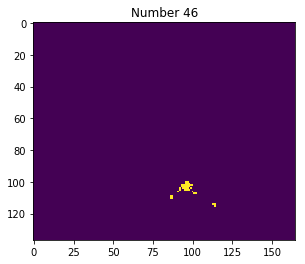

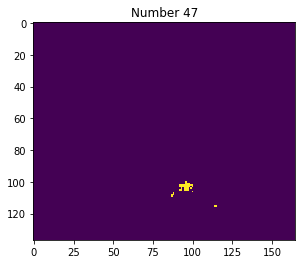

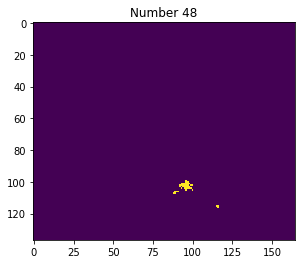

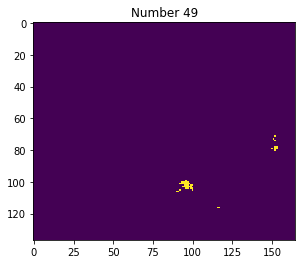

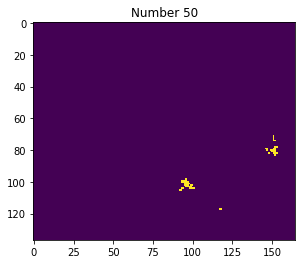

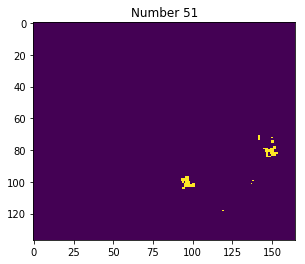

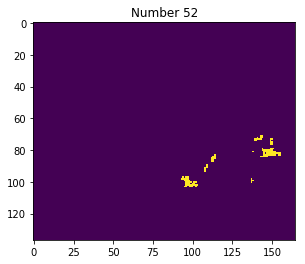

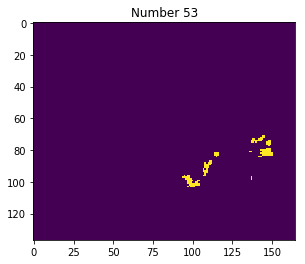

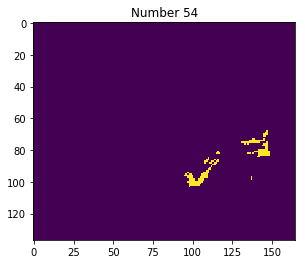

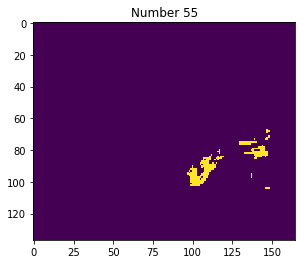

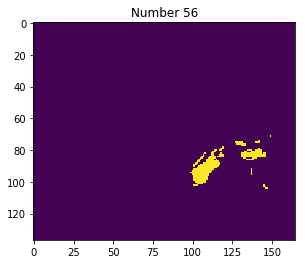

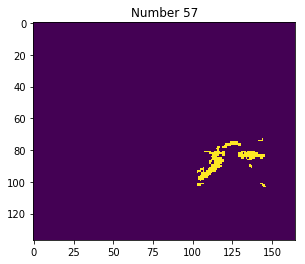

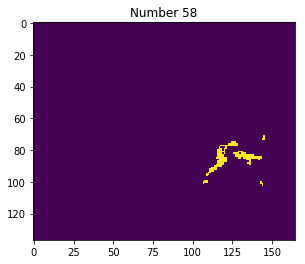

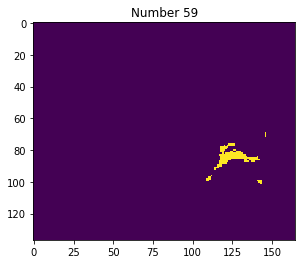

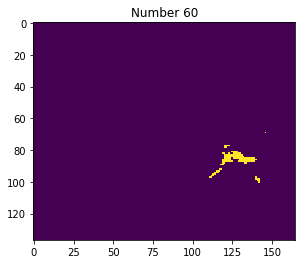

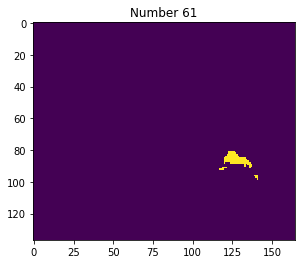

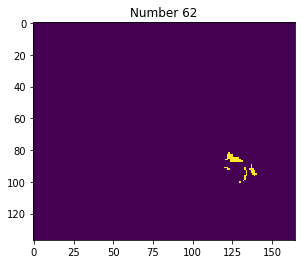

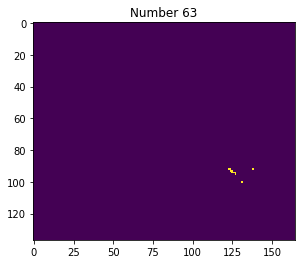

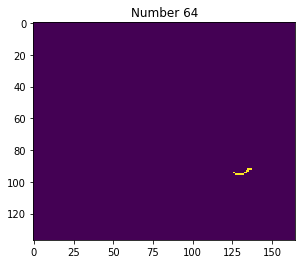

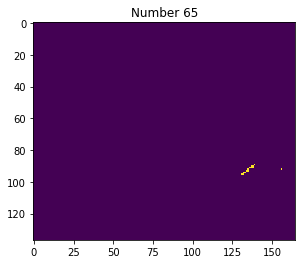

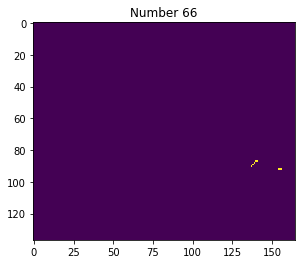

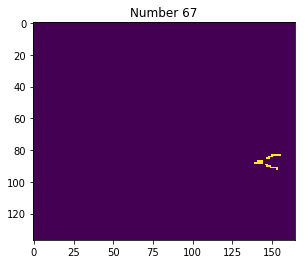

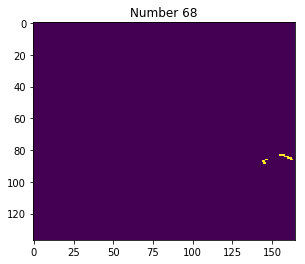

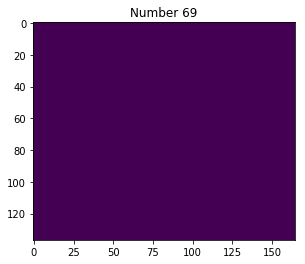

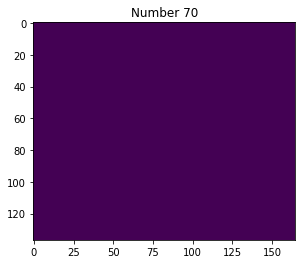

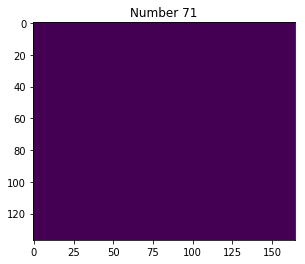

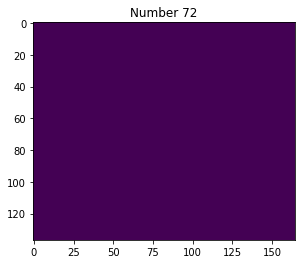

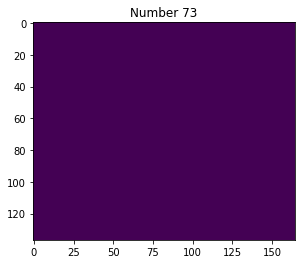

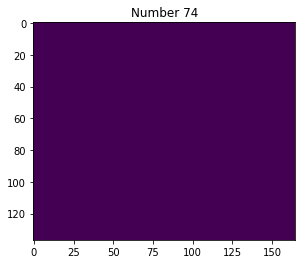

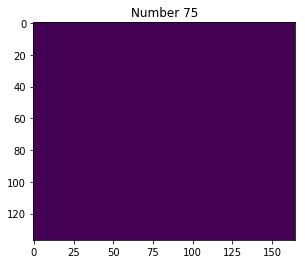

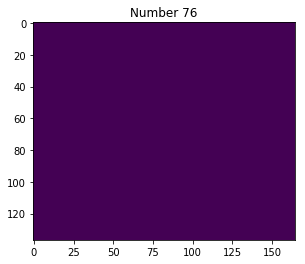

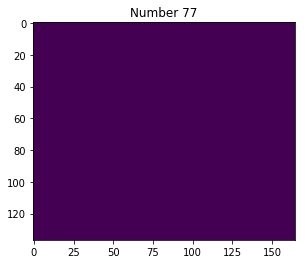

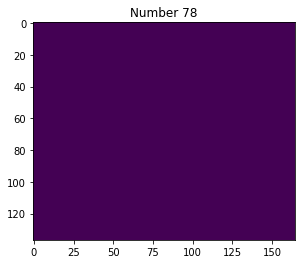

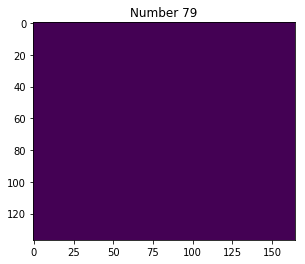

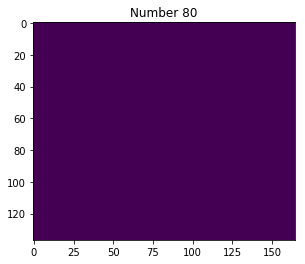

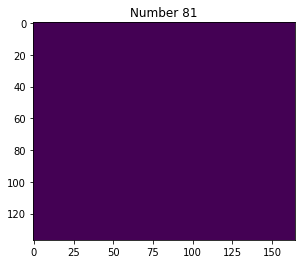

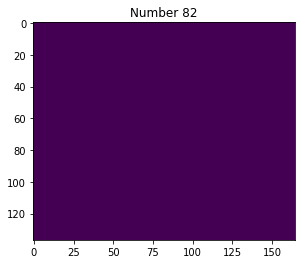

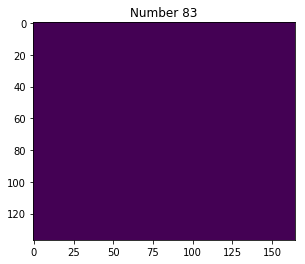

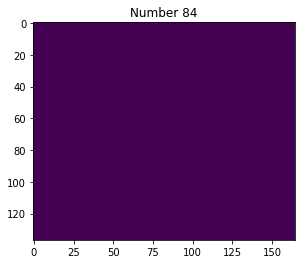

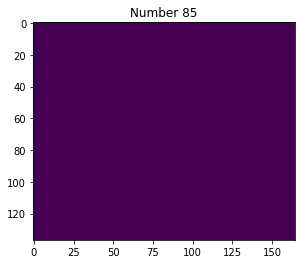

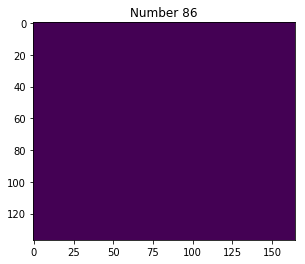

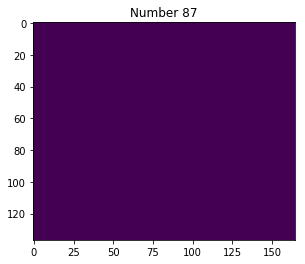

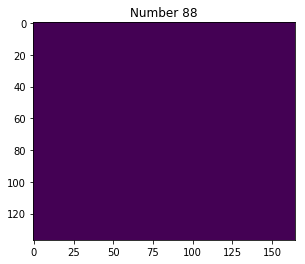

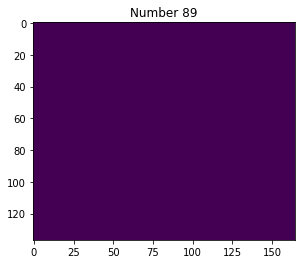

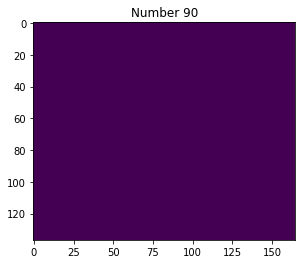

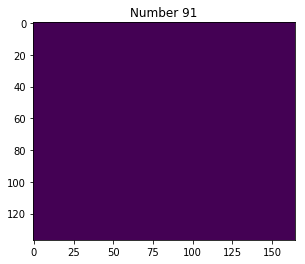

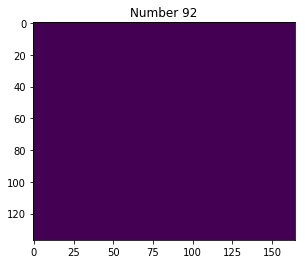

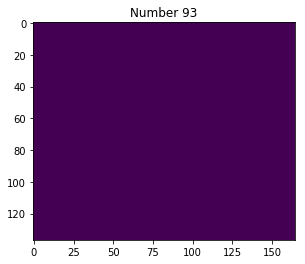

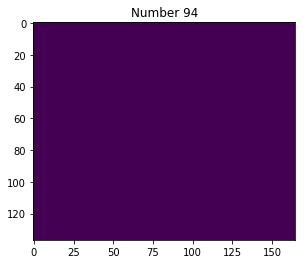

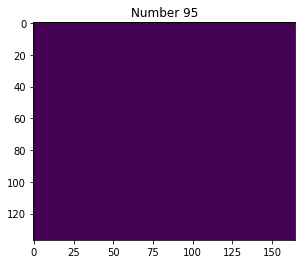

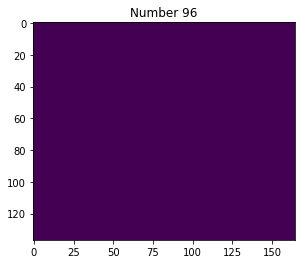

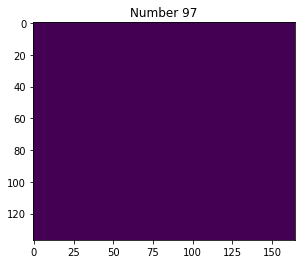

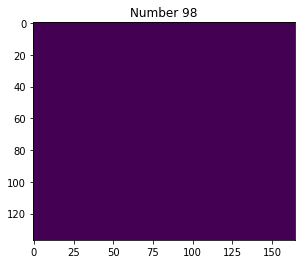

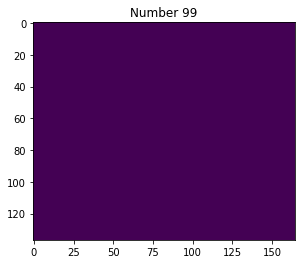

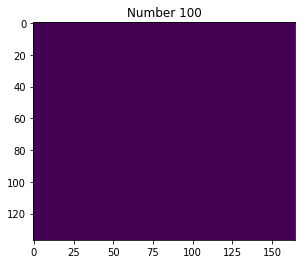

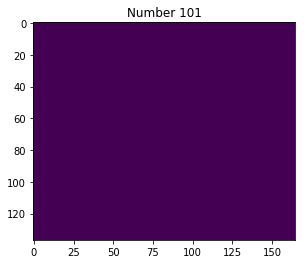

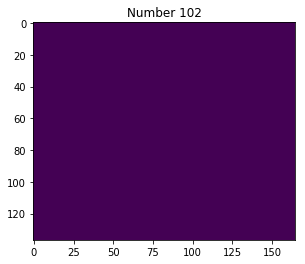

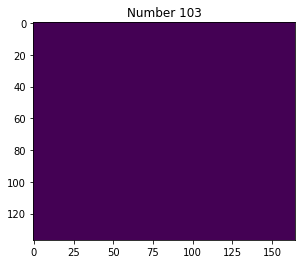

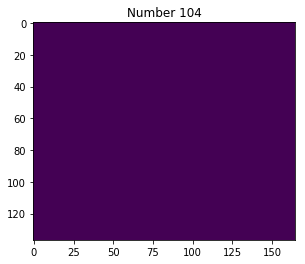

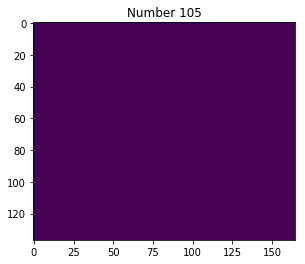

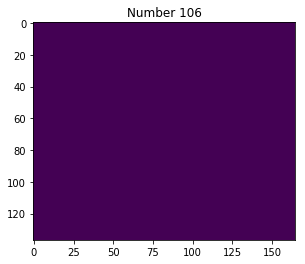

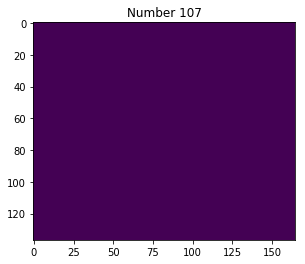

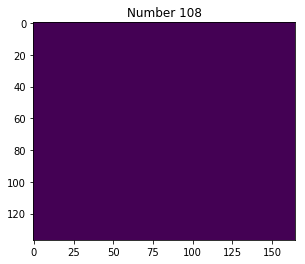

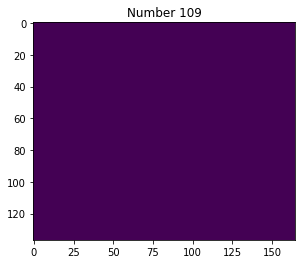

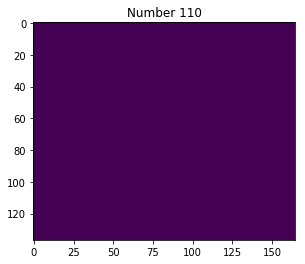

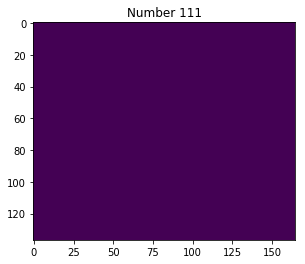

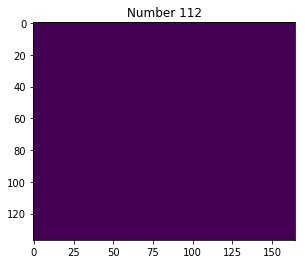

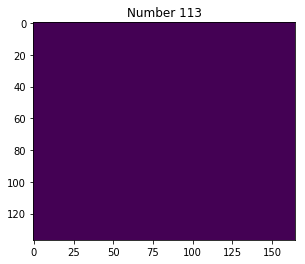

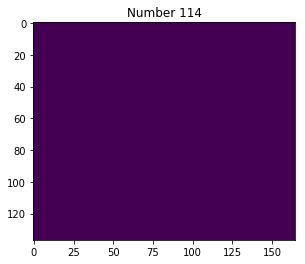

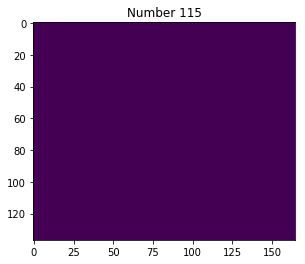

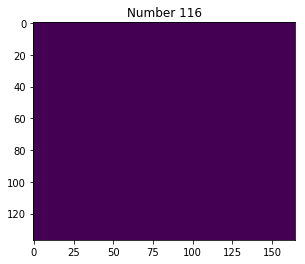

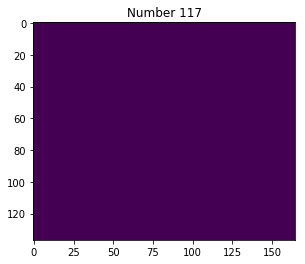

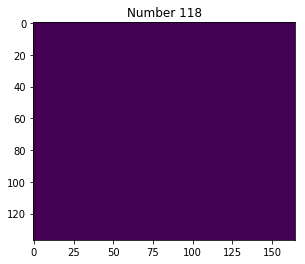

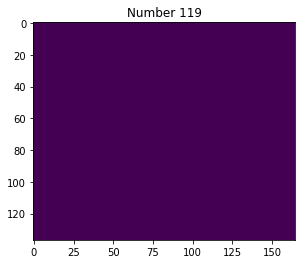

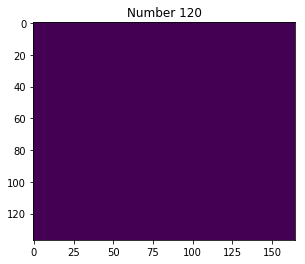

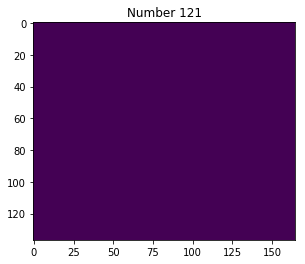

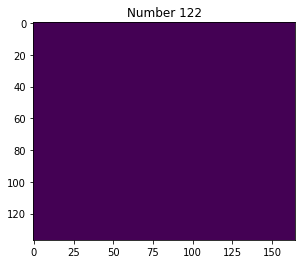

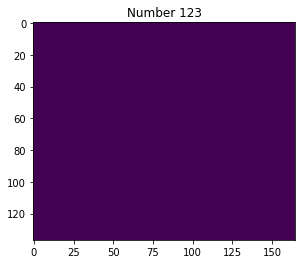

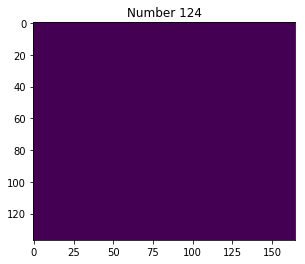

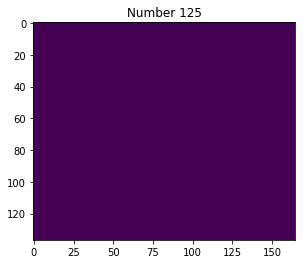

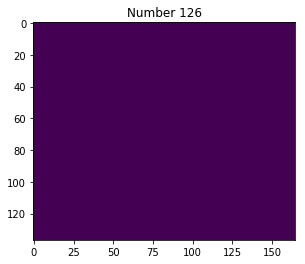

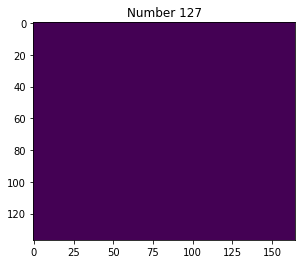

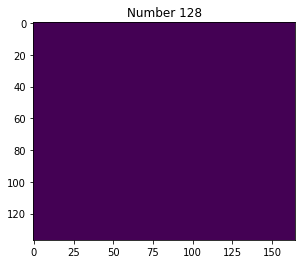

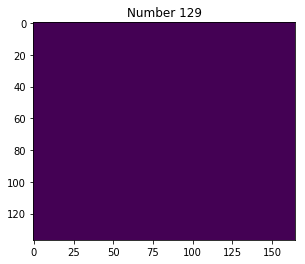

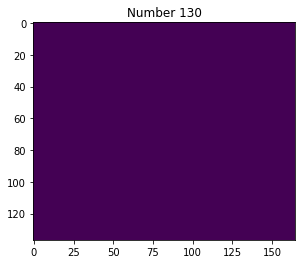

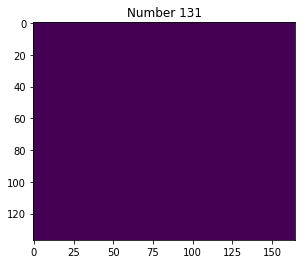

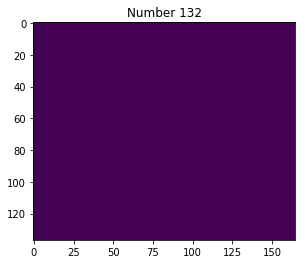

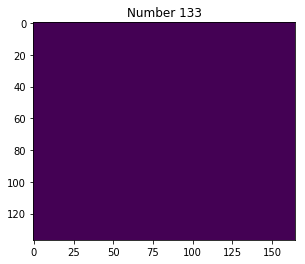

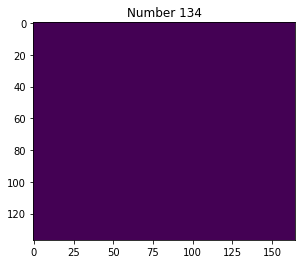

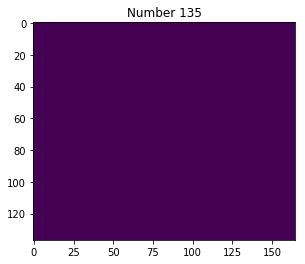

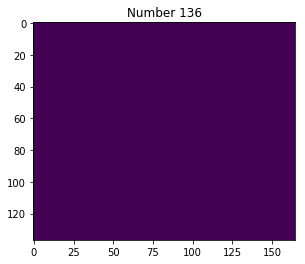

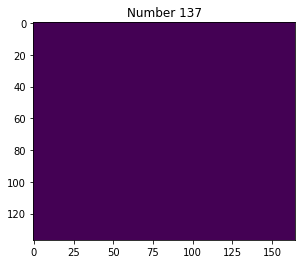

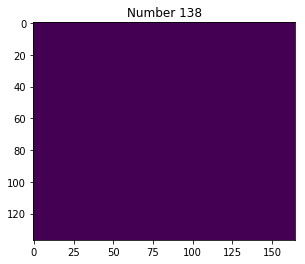

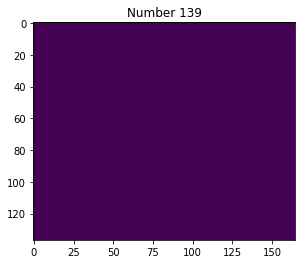

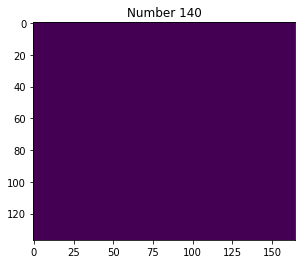

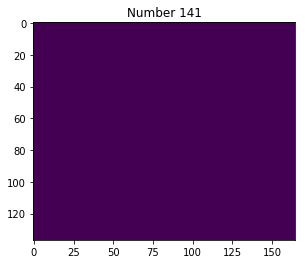

In [124]:
plt.figure(1);
for j in range(0,image_reco.shape[2]):
    plt.imshow(image_reco[:,:,j])
    plt.title('Number ' + str(j))
    plt.pause(0.1)
    plt.close()


In [125]:
dc

[0.31517694561000714,
 0.12366906474820144,
 0.07939042855313411,
 0.23384796106729316,
 0.0803003546252028,
 0.09440534584488519,
 0.0694710224166211,
 0.27174484770238605,
 0.16690148889988957,
 0.3050583657587549,
 0.9216509268975166,
 0.9999588790427041,
 0.9998712722591718,
 0.39220657477043697,
 0.3661681279009799,
 0.16897044804575787]

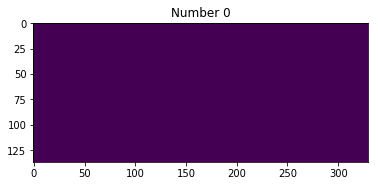

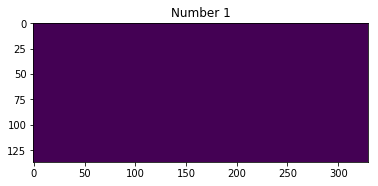

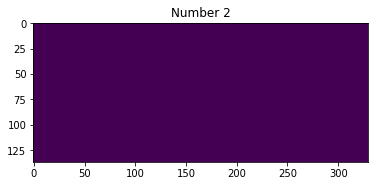

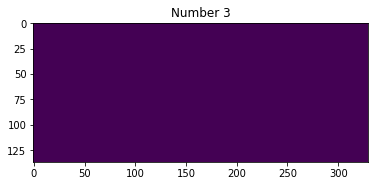

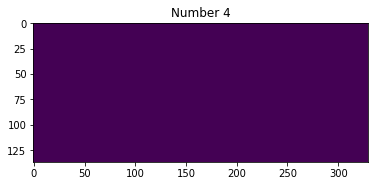

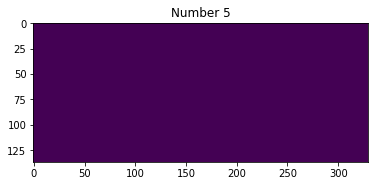

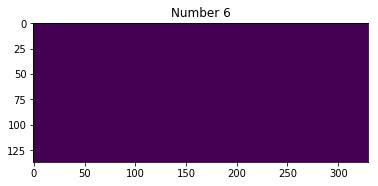

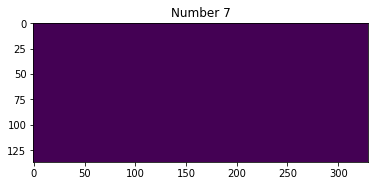

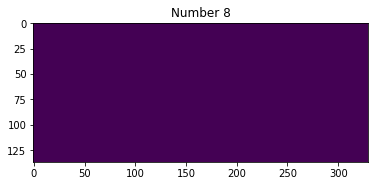

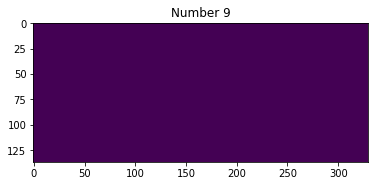

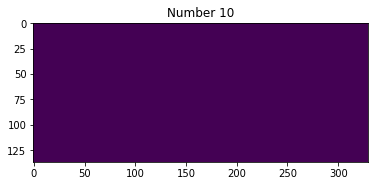

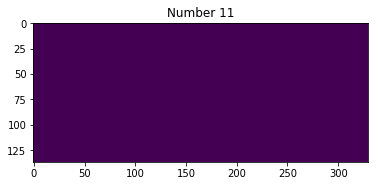

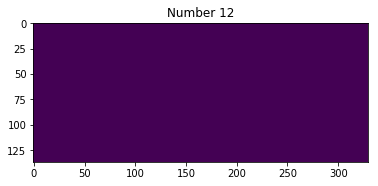

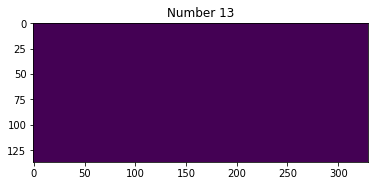

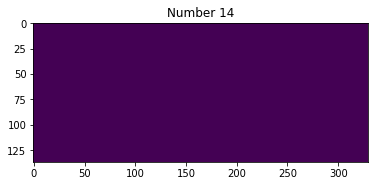

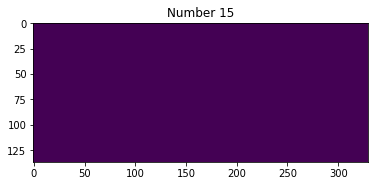

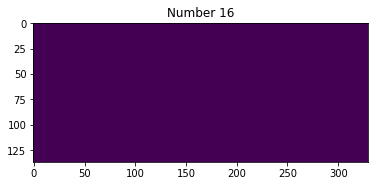

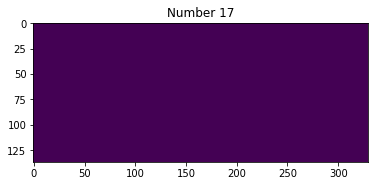

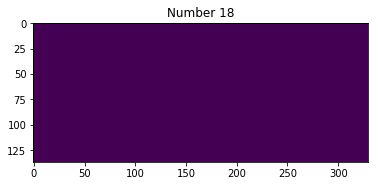

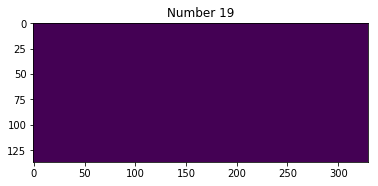

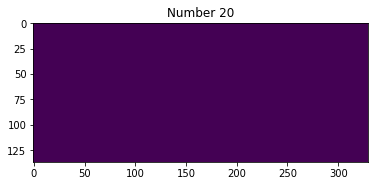

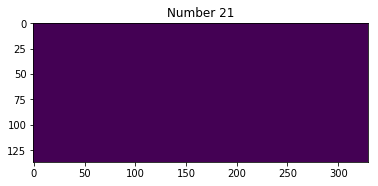

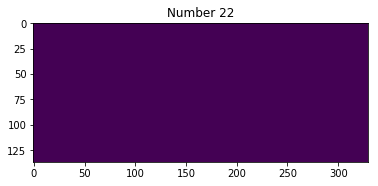

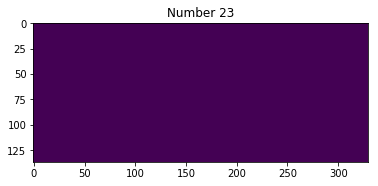

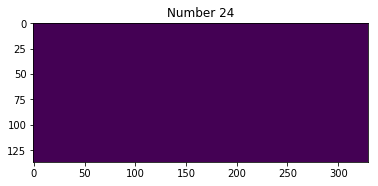

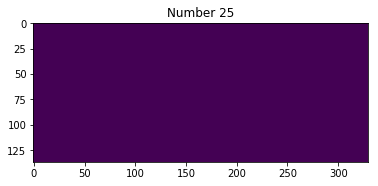

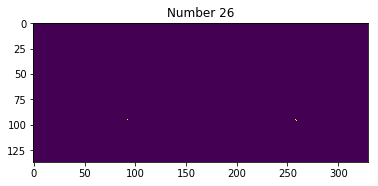

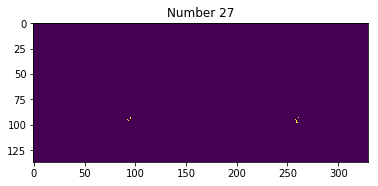

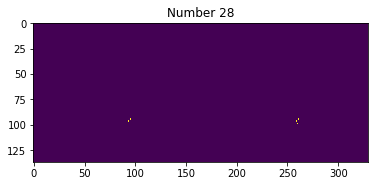

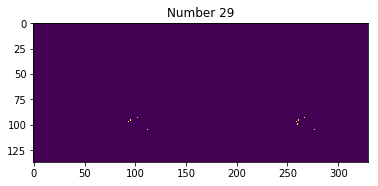

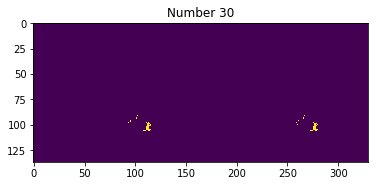

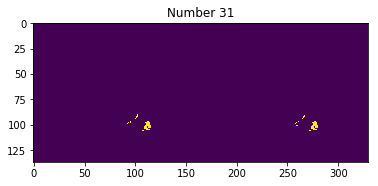

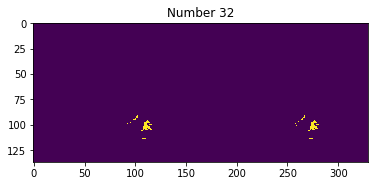

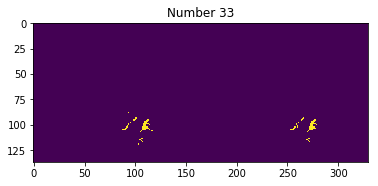

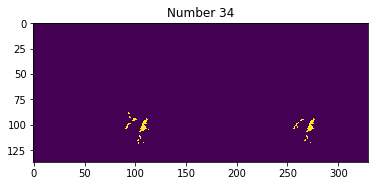

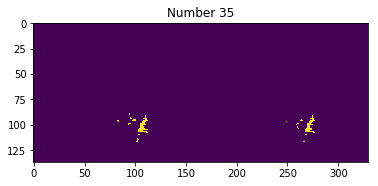

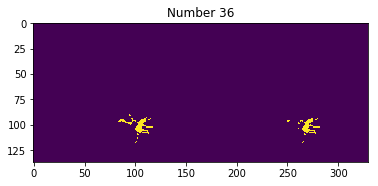

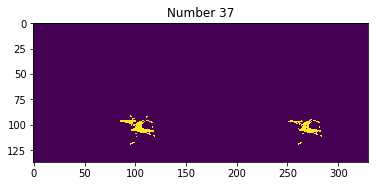

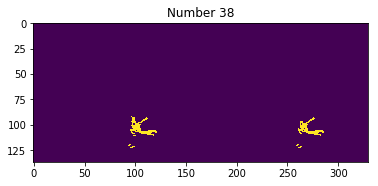

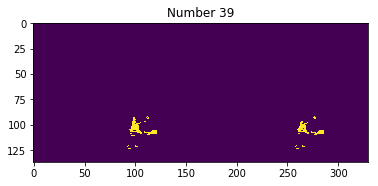

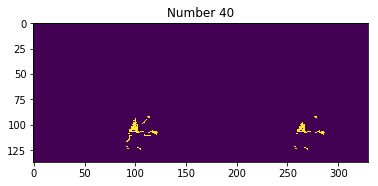

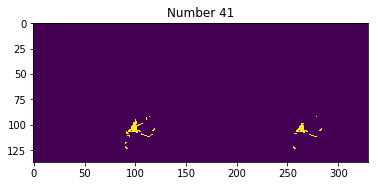

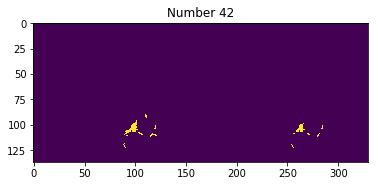

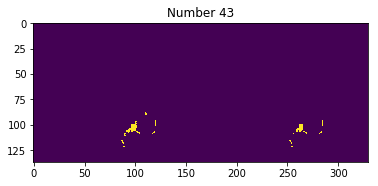

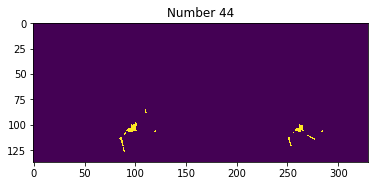

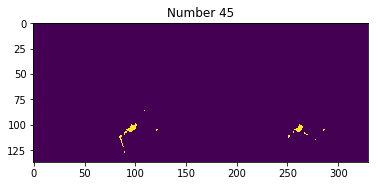

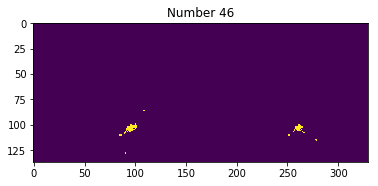

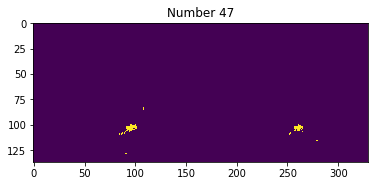

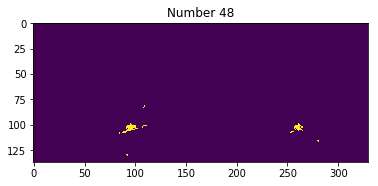

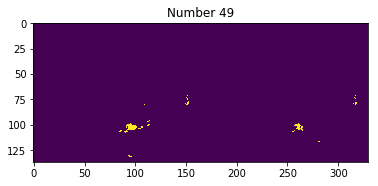

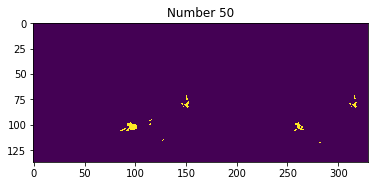

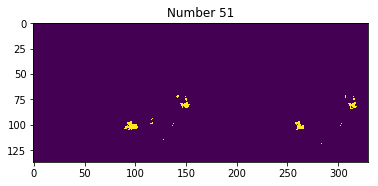

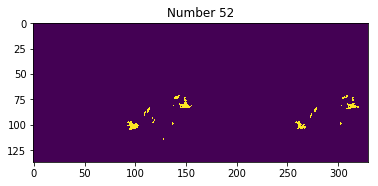

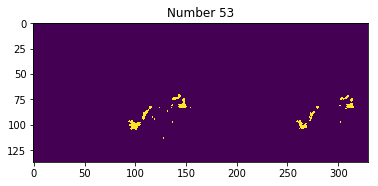

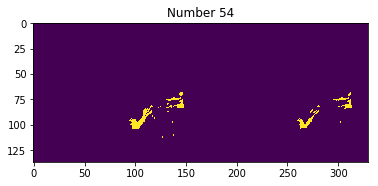

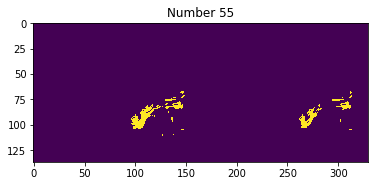

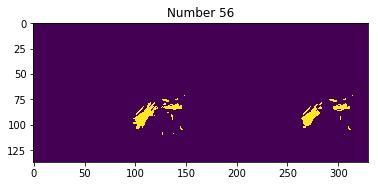

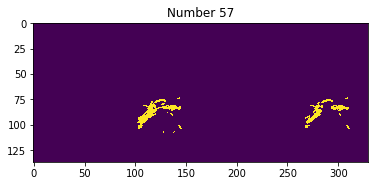

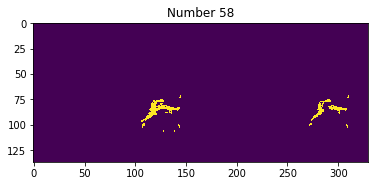

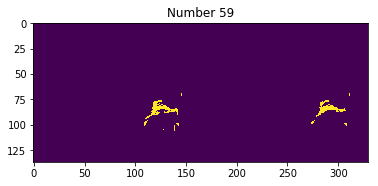

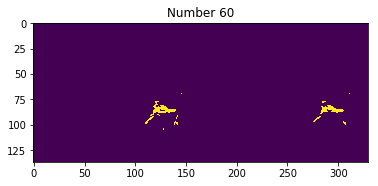

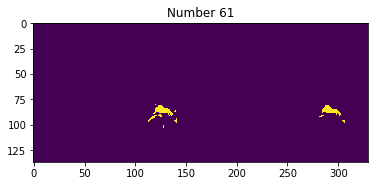

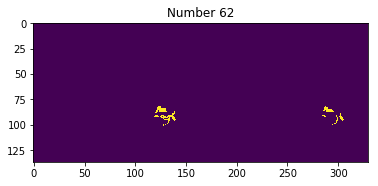

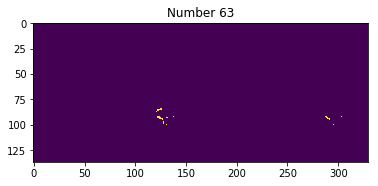

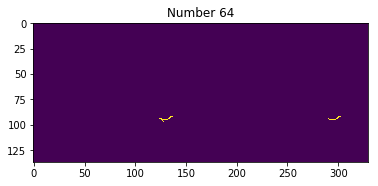

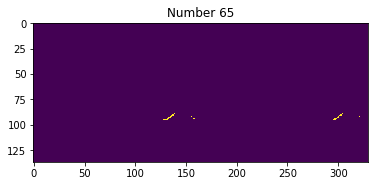

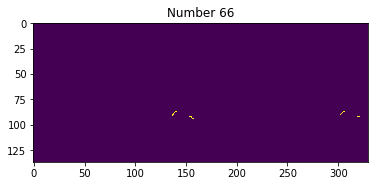

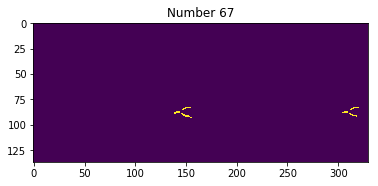

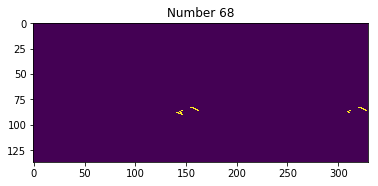

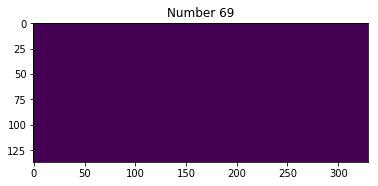

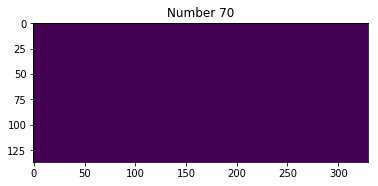

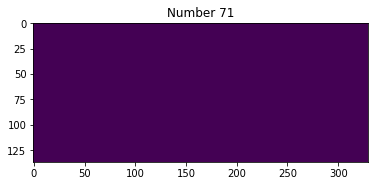

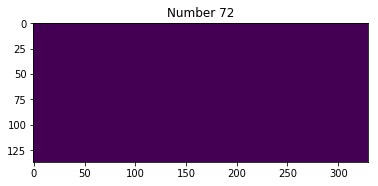

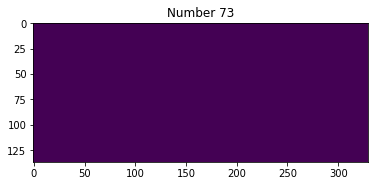

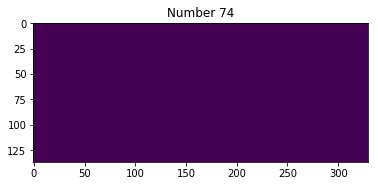

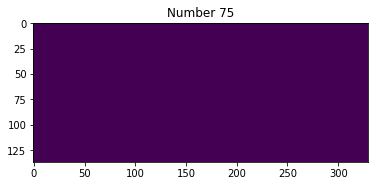

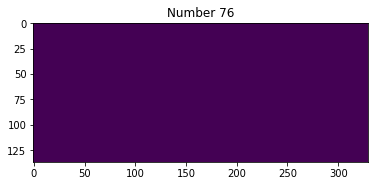

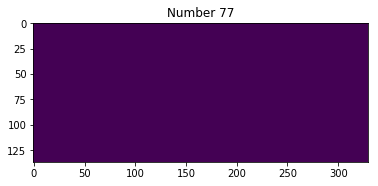

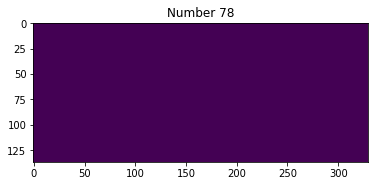

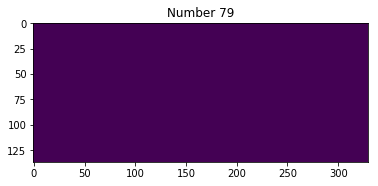

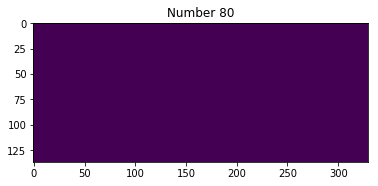

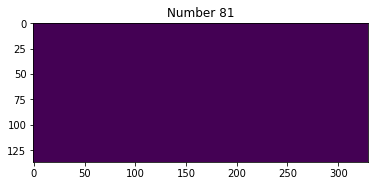

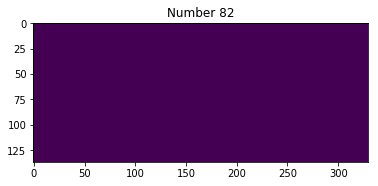

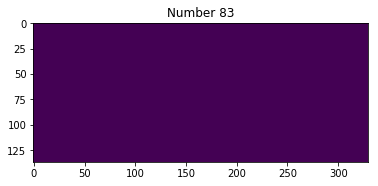

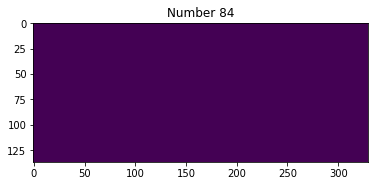

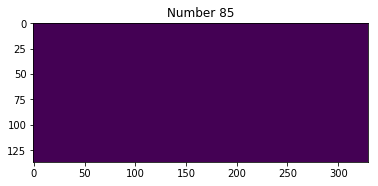

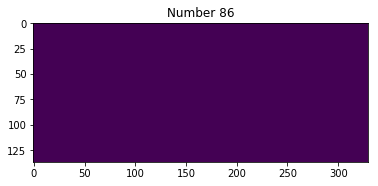

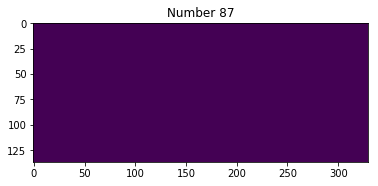

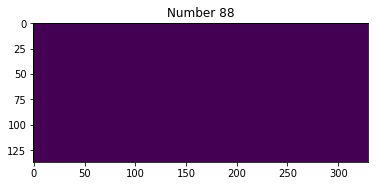

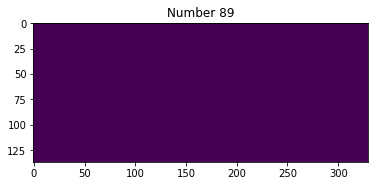

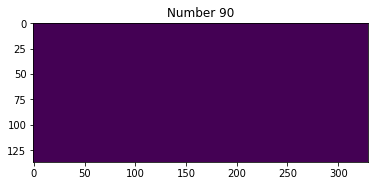

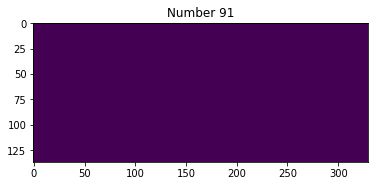

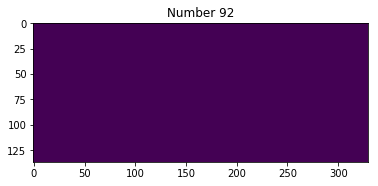

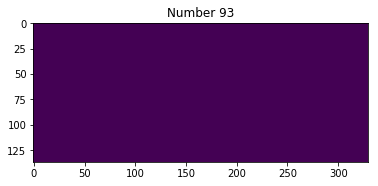

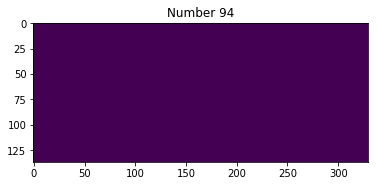

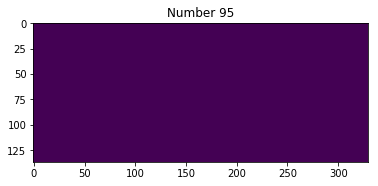

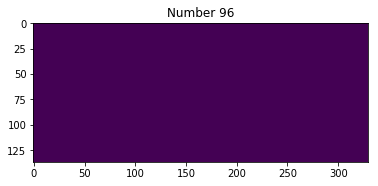

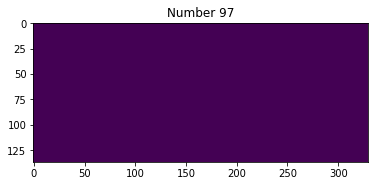

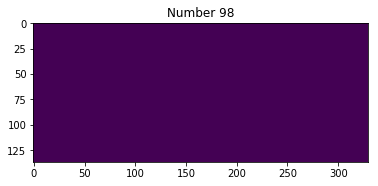

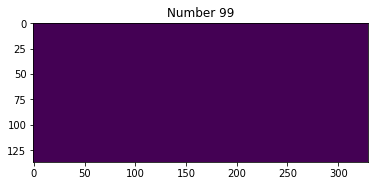

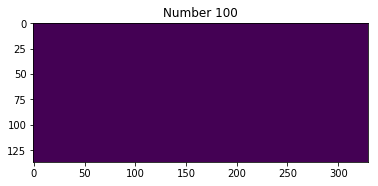

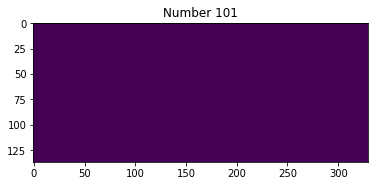

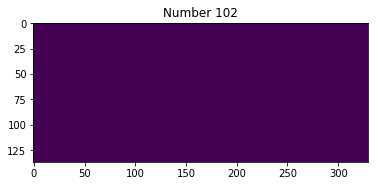

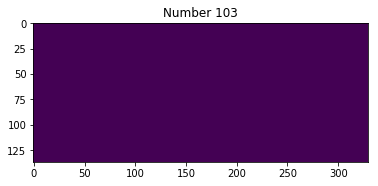

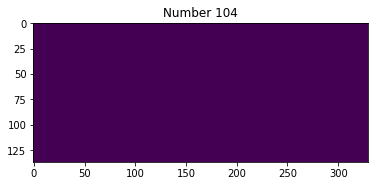

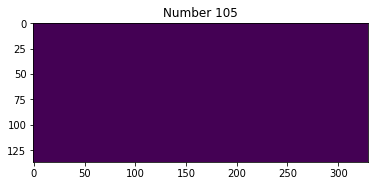

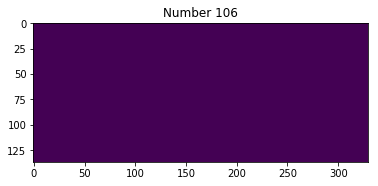

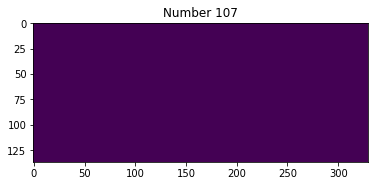

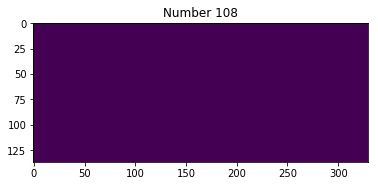

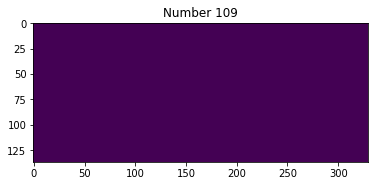

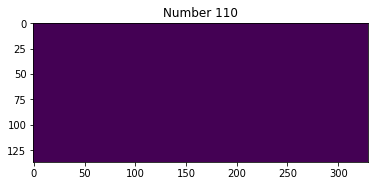

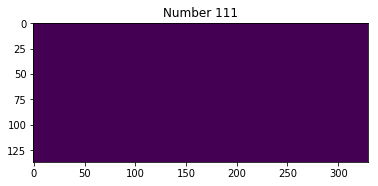

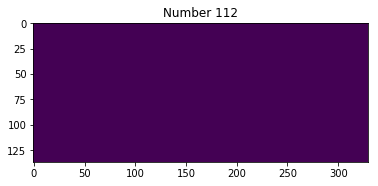

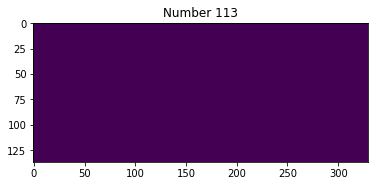

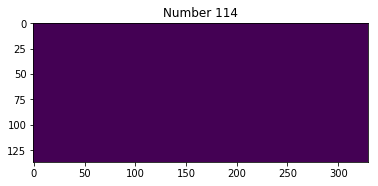

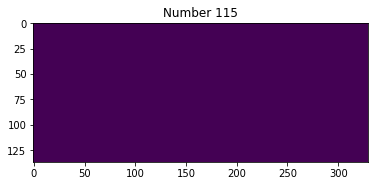

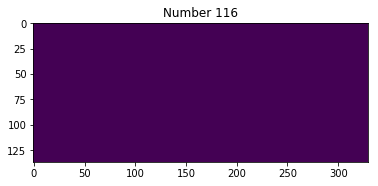

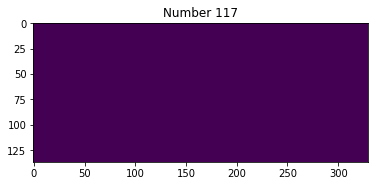

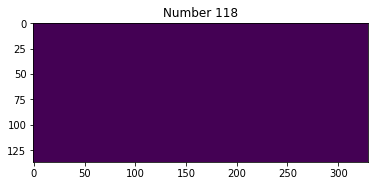

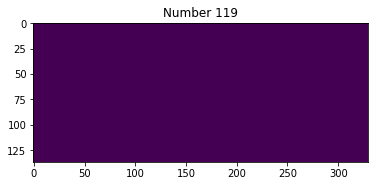

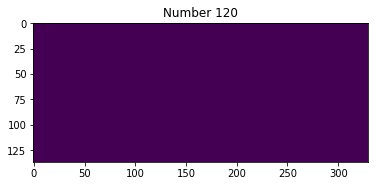

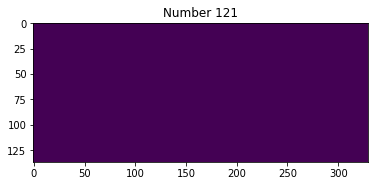

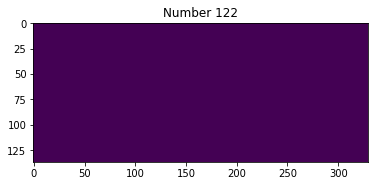

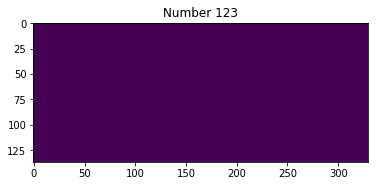

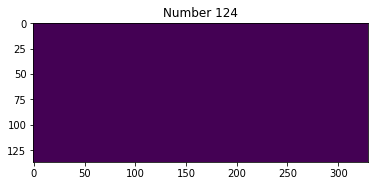

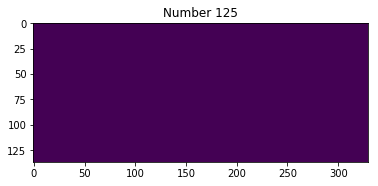

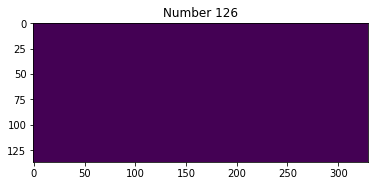

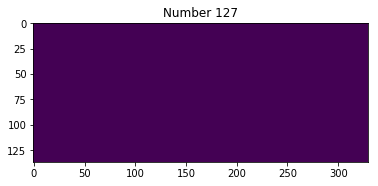

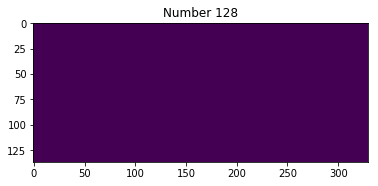

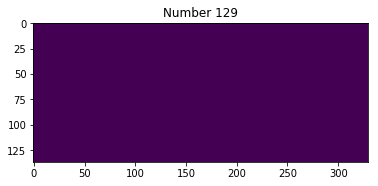

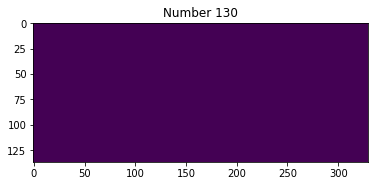

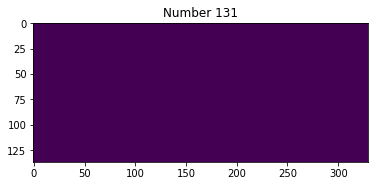

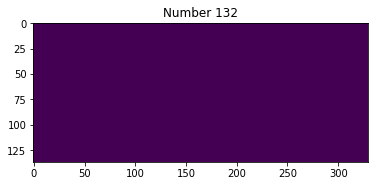

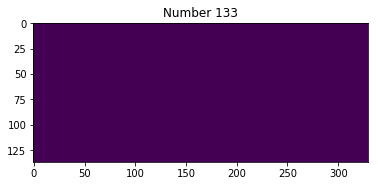

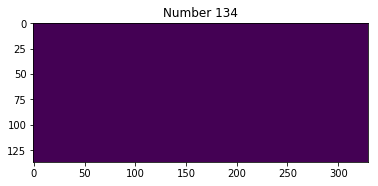

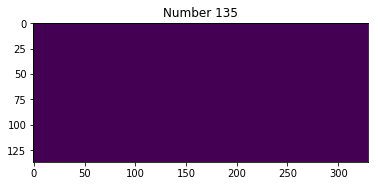

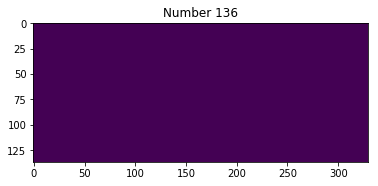

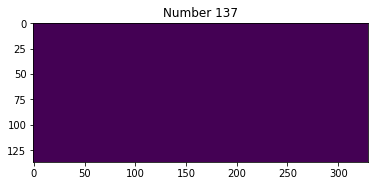

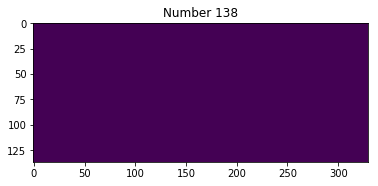

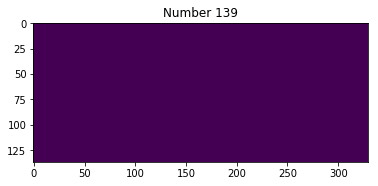

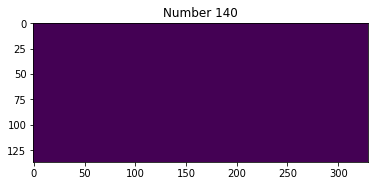

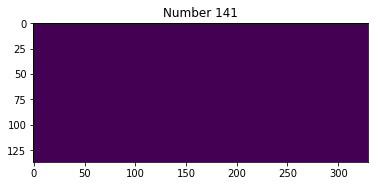

In [148]:
plt.figure(1);
for j in range(0,image_bn.shape[2]):
    plt.imshow(np.concatenate((image_bn[:,:,j],image_reco[:,:,j]),axis=1))
    plt.title('Number ' + str(j))
    plt.pause(0.1)
    plt.close()


In [157]:
bn.computedicecoef(image_bn[:,:,1],image_reco[:,:,1])

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/spatial/distance.py:1311: RuntimeWarning: invalid value encountered in double_scalars
  return float((ntf + nft) / np.array(2.0 * ntt + ntf + nft))


nan

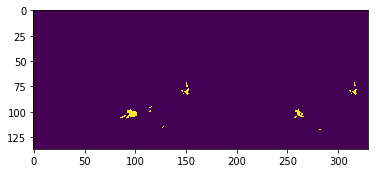

In [151]:
plt.imshow(np.concatenate((image_bn[:,:,50],image_reco[:,:,50]),axis=1))

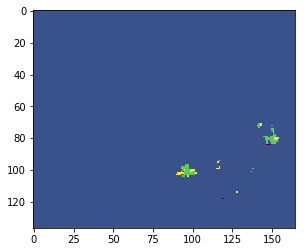

In [159]:
plt.imshow(image_bn[:,:,51]-image_reco[:,:,51]+2*image_bn[:,:,51])

(array([22510.,     0.,     0.,     0.,     0.,    42.,     0.,     0.,
            0.,    53.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

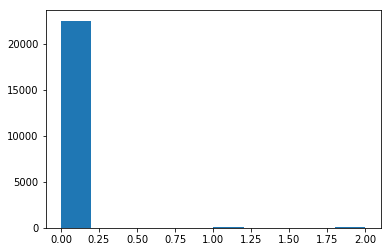

In [160]:
plt.hist(np.ndarray.flatten(image_bn[:,:,50])+np.ndarray.flatten(image_reco[:,:,50]))

In [168]:
np.sum(np.ndarray.flatten(image_bn[:,:,51])+np.ndarray.flatten(image_reco[:,:,51])==2)

79

In [167]:
bn.computedicecoef(image_bn[:,:,51],image_reco[:,:,51])

0.18134715025906736

In [180]:
for i in range(100):
    print((2*np.sum(np.ndarray.flatten(image_bn[:,:,i])+np.ndarray.flatten(image_reco[:,:,i])==2))/(np.sum((np.ndarray.flatten(image_reco[:,:,i])==1))+np.sum(np.ndarray.flatten(image_bn[:,:,i])==1)))

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
0.6666666666666666
0.6
0.8888888888888888
0.8333333333333334
0.9393939393939394
0.9574468085106383
0.9482758620689655
0.9305555555555556
0.8859060402684564
0.8863636363636364
0.8736462093862816
0.907608695652174
0.9463722397476341
0.9291338582677166
0.8246445497630331
0.8114285714285714
0.7619047619047619
0.8260869565217391
0.7310344827586207
0.7130434782608696
0.7070707070707071
0.7608695652173914
0.693069306930693
0.6446280991735537
0.7162162162162162
0.8186528497409327
0.8044280442804428
0.8206686930091185
0.802660753880266
0.8180354267310789
0.8715728715728716
0.8399311531841652
0.7858823529411765
0.827027027027027
0.8378378378378378
0.8421052631578947
0.7252747252747253
0.5128205128205128
0.8484848484848485
0.8
0.7619047619047619
0.8767123287671232
0.8
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
